In [1]:
!nvidia-smi

Thu May 29 14:47:48 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      Off| 00000000:1A:00.0 Off |                  N/A |
| 16%   27C    P8                1W / 250W|     18MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' #change to the GPU you want to use

# Simulation pipeline

## Dynamic of particules

In [3]:
import jax.numpy as jnp 
import jax
jax.config.update("jax_debug_nans", True) # notice if there are any nans immediately
from jax import vmap, random 
import matplotlib.pyplot as plt
import numpy as np
from diffrax import diffeqsolve, ODETerm, Dopri5,LeapfrogMidpoint, SaveAt
from jaxpm.painting import cic_paint, cic_read


In [4]:
@jax.jit 
def pairwise_forces(pos, G, softening, length):
    # dx_ij = pos_i - pos_j with minimal-image, branchless
    dx = pos[:,None,:] - pos[None,:,:]           # (N,N,3)
    dx = dx - length*jnp.round(dx/length)                  # periodic, no comparison so better for XLA
    r2 = jnp.sum(dx**2, axis=-1) + softening**2           # (N,N)
    inv_r3 = jnp.where(jnp.eye(pos.shape[0]), 0., r2**-1.5)
    F = jnp.einsum('ij,ijc->ic', inv_r3, dx)  # (N,3)
    F = -G*F
    return F

In [57]:
def make_diffrax_ode(softening,
               G, length):

    def nbody_ode(t,state,args):
        """
        state is a tuple (position, velocities)
        """
        pos, vel  = state

        forces = pairwise_forces(pos, G=G, softening=softening, length=length)


        # Computes the update of position (drift)
        dpos = vel

        # Computes the update of velocity (kick)
        dvel = forces
        return jnp.stack([dpos, dvel]) # stack to get (2, N, 3) shape

    return nbody_ode

## Plot functions

In [58]:
def plot_density_fields_and_positions(G, tf, dt, length, n_part, input_field, init_pos, final_pos, output_field):
    """
    Plot density fields and particle positions in various projections.
    
    Parameters:
    -----------
    input_field : array
        The input density field (3D array)
    init_pos : array
        Initial particle positions (N x 3 array)
    final_pos : array
        Final particle positions (N x 3 array)
    output_field : array
        The output density field (3D array)
    """
    # Create figure with a grid layout
    fig = plt.figure(figsize=(25, 20))
    gs = plt.GridSpec(4, 4, figure=fig)

    title = 'Simulation with parameters:'
    param_info = f'G={G}, tf={tf}, dt={dt}, L={length}, N={n_part}'
    title += f'\n{param_info}'
    fig.suptitle(title, y=1.0, fontsize=22)
    
    # First row: Input density field (3 plots)
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(jnp.sum(input_field, axis=0), cmap='inferno')
    ax1.set_title('Input Density Field (Projection X-Y)')
    fig.colorbar(im1, ax=ax1, orientation='vertical')

    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(jnp.sum(input_field, axis=1), cmap='inferno')
    ax2.set_title('Input Density Field (Projection X-Z)')
    fig.colorbar(im2, ax=ax2, orientation='vertical')

    ax3 = fig.add_subplot(gs[0, 2])
    im3 = ax3.imshow(jnp.sum(input_field, axis=2), cmap='inferno')
    ax3.set_title('Input Density Field (Projection Y-Z)')
    fig.colorbar(im3, ax=ax3, orientation='vertical')
    
    # Empty plot in top-right corner
    fig.add_subplot(gs[0, 3]).set_visible(False)

    # Second row: Initial positions (4 plots)
    ax4 = fig.add_subplot(gs[1, 0], projection='3d')
    ax4.scatter(init_pos[:, 0], init_pos[:, 1], init_pos[:, 2], c='r', marker='o', alpha=0.5, s=1)
    ax4.set_title('Initial Particle Positions (3D)')
    ax4.set_xlabel('X'); ax4.set_ylabel('Y'); ax4.set_zlabel('Z')

    ax5 = fig.add_subplot(gs[1, 1])
    ax5.scatter(init_pos[:, 0], init_pos[:, 1], c='r', marker='o', alpha=0.5, s=1)
    ax5.set_title('Initial Positions (X-Y)')
    ax5.set_xlabel('X'); ax5.set_ylabel('Y')

    ax6 = fig.add_subplot(gs[1, 2])
    ax6.scatter(init_pos[:, 0], init_pos[:, 2], c='r', marker='o', alpha=0.5, s=1)
    ax6.set_title('Initial Positions (X-Z)')
    ax6.set_xlabel('X'); ax6.set_ylabel('Z')

    ax7 = fig.add_subplot(gs[1, 3])
    ax7.scatter(init_pos[:, 1], init_pos[:, 2], c='r', marker='o', alpha=0.5, s=1)
    ax7.set_title('Initial Positions (Y-Z)')
    ax7.set_xlabel('Y'); ax7.set_ylabel('Z')

    # Third row: Final positions (4 plots)
    ax8 = fig.add_subplot(gs[2, 0], projection='3d')
    ax8.scatter(final_pos[:, 0], final_pos[:, 1], final_pos[:, 2], c='b', marker='o', alpha=0.5, s=1)
    ax8.set_title('Final Particle Positions (3D)')
    ax8.set_xlabel('X'); ax8.set_ylabel('Y'); ax8.set_zlabel('Z')

    ax9 = fig.add_subplot(gs[2, 1])
    ax9.scatter(final_pos[:, 0], final_pos[:, 1], c='b', marker='o', alpha=0.5, s=1)
    ax9.set_title('Final Positions (X-Y)')
    ax9.set_xlabel('X'); ax9.set_ylabel('Y')

    ax10 = fig.add_subplot(gs[2, 2])
    ax10.scatter(final_pos[:, 0], final_pos[:, 2], c='b', marker='o', alpha=0.5, s=1)
    ax10.set_title('Final Positions (X-Z)')
    ax10.set_xlabel('X'); ax10.set_ylabel('Z')

    ax11 = fig.add_subplot(gs[2, 3])
    ax11.scatter(final_pos[:, 1], final_pos[:, 2], c='b', marker='o', alpha=0.5, s=1)
    ax11.set_title('Final Positions (Y-Z)')
    ax11.set_xlabel('Y'); ax11.set_ylabel('Z')

    # Fourth row: Output density field (3 plots)
    ax12 = fig.add_subplot(gs[3, 0])
    im12 = ax12.imshow(jnp.sum(output_field, axis=0), cmap='inferno')
    ax12.set_title('Output Density Field (Projection X-Y)')
    fig.colorbar(im12, ax=ax12, orientation='vertical')

    ax13 = fig.add_subplot(gs[3, 1])
    im13 = ax13.imshow(jnp.sum(output_field, axis=1), cmap='inferno')
    ax13.set_title('Output Density Field (Projection X-Z)')
    fig.colorbar(im13, ax=ax13, orientation='vertical')

    ax14 = fig.add_subplot(gs[3, 2])
    im14 = ax14.imshow(jnp.sum(output_field, axis=2), cmap='inferno')
    ax14.set_title('Output Density Field (Projection Y-Z)')
    fig.colorbar(im14, ax=ax14, orientation='vertical')
    
    # Empty plot in bottom-right corner
    fig.add_subplot(gs[3, 3]).set_visible(False)

    plt.tight_layout()
    return fig


In [59]:
def plot_all_timesteps(sol,
                       length,
                       G,    
                       tf,
                       dt,
                       n_part,
                       skip=1,            # save memory: plot every 'skip'-th step
                       s=1,               # marker size for scatters
                       cmap='inferno'):
    """
    Parameters
    ----------
    sol   : diffrax solution object  (ys shape = (T, 2, N, 3))
    boxL  : box length used in cic_paint
    skip  : int, plot every `skip`-th stored step
    s     : matplotlib scatter size
    """
    # How many rows will we draw?
    steps = sol.ts[::skip]       # time steps to plot
    nrows = len(steps)

    # Pre-build the canvas
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=4,
                             figsize=(24, 4 * nrows),
                             squeeze=False)
    
    # Add global title with simulation parameters
    title = 'Simulation with parameters:'
    param_info = f'G={G}, tf={tf}, dt={dt}, L={length}, N={n_part}'
    title += f'\n{param_info}'
    fig.suptitle(title, y=1.0, fontsize=22)

    for row, t in enumerate(steps): 
        # Check if sol.ys is a tuple (central mass case) or array (first simulation)
        if isinstance(sol.ys, tuple):
            pos_t = sol.ys[0][row]  # For tuple format: (positions, velocities)
        else:
            pos_t = sol.ys[row][0]
        # --- projections ----------------------------------------------------
        axes[row, 0].scatter(pos_t[:, 0], pos_t[:, 1], s=s)
        axes[row, 1].scatter(pos_t[:, 0], pos_t[:, 2], s=s)
        axes[row, 2].scatter(pos_t[:, 1], pos_t[:, 2], s=s)

        for col, lbl in zip(range(3),
                            ['XY', 'XZ', 'YZ']):
            ax = axes[row, col]
            ax.set_title(f't={t:.2f}  ({lbl})')
            ax.set_xlabel(lbl[0]); ax.set_ylabel(lbl[1])
            ax.set_xlim(0, length);  ax.set_ylim(0, length)

        # --- density slice --------------------------------------------------
        field_t = cic_paint(jnp.zeros((length, length, length)), pos_t)
        im = axes[row, 3].imshow(jnp.sum(field_t, axis=2),
                                 cmap=cmap, origin='lower')
        axes[row, 3].set_title('Σ ρ(x,y)')
        fig.colorbar(im, ax=axes[row, 3], orientation='vertical')

    plt.tight_layout()
    return fig, axes

In [60]:
def plot_trajectories(solution, G, tf, dt, length, n_part, particle_indices=None, box=None, title=None, figsize=(20, 5), zoom=True, padding=0.1, smooth_window=5, arrow_frac=0.7):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np

    def smooth_trajectory(traj, window):
        if window < 2:
            return traj
        kernel = np.ones(window) / window
        traj_padded = np.pad(traj, ((window//2, window-1-window//2), (0,0)), mode='edge')
        smoothed = np.vstack([
            np.convolve(traj_padded[:, dim], kernel, mode='valid')
            for dim in range(traj.shape[1])
        ]).T
        return smoothed

    if isinstance(solution.ys, tuple):
        positions = solution.ys[0]
    else:
        positions = solution.ys[:, 0]
    n_timesteps, n_particles, n_dims = positions.shape

    if particle_indices is None:
        if n_particles > 50:
            particle_indices = np.random.choice(n_particles, 50, replace=False)
        else:
            particle_indices = np.arange(n_particles)

    fig = plt.figure(figsize=figsize)
    ax_3d = fig.add_subplot(1, 4, 1, projection='3d')
    ax_xy = fig.add_subplot(1, 4, 2)
    ax_xz = fig.add_subplot(1, 4, 3)
    ax_yz = fig.add_subplot(1, 4, 4)

    # Create parameter info string
    param_info = f'G={G}, tf={tf}, dt={dt}, L={length}, N={n_part}'
    if title:
        title = f'{title}\n{param_info}'
    else:
        title = param_info

    ax_3d.set_title('3D Trajectories (Smoothed)')
    ax_xy.set_title('XY Projection')
    ax_xz.set_title('XZ Projection')
    ax_yz.set_title('YZ Projection')

    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')
    ax_xy.set_xlabel('X')
    ax_xy.set_ylabel('Y')
    ax_xz.set_xlabel('X')
    ax_xz.set_ylabel('Z')
    ax_yz.set_xlabel('Y')
    ax_yz.set_ylabel('Z')

    # Plot final positions of all particles in background with transparency
    final_pos_all = positions[-1, :]
    ax_3d.scatter(final_pos_all[:, 0], final_pos_all[:, 1], final_pos_all[:, 2], 
                  color='lightgray', alpha=0.4, s=5)
    ax_xy.scatter(final_pos_all[:, 0], final_pos_all[:, 1], color='lightgray', alpha=0.2, s=5)
    ax_xz.scatter(final_pos_all[:, 0], final_pos_all[:, 2], color='lightgray', alpha=0.2, s=5)
    ax_yz.scatter(final_pos_all[:, 1], final_pos_all[:, 2], color='lightgray', alpha=0.2, s=5)

    colors = plt.cm.jet(np.linspace(0, 1, len(particle_indices)))
    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')
    z_min, z_max = float('inf'), float('-inf')

    for i, p_idx in enumerate(particle_indices):
        traj = positions[:, p_idx]
        traj_smooth = smooth_trajectory(traj, window=smooth_window)
        x_min = min(x_min, traj_smooth[:, 0].min())
        x_max = max(x_max, traj_smooth[:, 0].max())
        y_min = min(y_min, traj_smooth[:, 1].min())
        y_max = max(y_max, traj_smooth[:, 1].max())
        z_min = min(z_min, traj_smooth[:, 2].min())
        z_max = max(z_max, traj_smooth[:, 2].max())
        ax_3d.plot(traj_smooth[:, 0], traj_smooth[:, 1], traj_smooth[:, 2], color=colors[i], linewidth=1.0, alpha=0.7)
        ax_xy.plot(traj_smooth[:, 0], traj_smooth[:, 1], color=colors[i], linewidth=1.0)
        ax_xz.plot(traj_smooth[:, 0], traj_smooth[:, 2], color=colors[i], linewidth=1.0)
        ax_yz.plot(traj_smooth[:, 1], traj_smooth[:, 2], color=colors[i], linewidth=1.0)
        ax_3d.scatter(traj_smooth[0, 0], traj_smooth[0, 1], traj_smooth[0, 2], color=colors[i], marker='o', s=20)
        ax_3d.scatter(traj_smooth[-1, 0], traj_smooth[-1, 1], traj_smooth[-1, 2], color=colors[i], marker='s', s=20)

        # Add arrows to indicate direction (at arrow_frac along the trajectory)
        idx = int(len(traj_smooth) * arrow_frac)
        if idx < len(traj_smooth) - 1:
            # 3D arrow
            ax_3d.quiver(
                traj_smooth[idx, 0], traj_smooth[idx, 1], traj_smooth[idx, 2],
                traj_smooth[idx+1, 0] - traj_smooth[idx, 0],
                traj_smooth[idx+1, 1] - traj_smooth[idx, 1],
                traj_smooth[idx+1, 2] - traj_smooth[idx, 2],
                color=colors[i], arrow_length_ratio=0.3, linewidth=1.5, alpha=0.8
            )
            # 2D arrows
            ax_xy.annotate('', xy=(traj_smooth[idx+1, 0], traj_smooth[idx+1, 1]), 
                           xytext=(traj_smooth[idx, 0], traj_smooth[idx, 1]),
                           arrowprops=dict(facecolor=colors[i], edgecolor=colors[i], arrowstyle='->', lw=1.5, alpha=0.8))
            ax_xz.annotate('', xy=(traj_smooth[idx+1, 0], traj_smooth[idx+1, 2]), 
                           xytext=(traj_smooth[idx, 0], traj_smooth[idx, 2]),
                           arrowprops=dict(facecolor=colors[i], edgecolor=colors[i], arrowstyle='->', lw=1.5, alpha=0.8))
            ax_yz.annotate('', xy=(traj_smooth[idx+1, 1], traj_smooth[idx+1, 2]), 
                           xytext=(traj_smooth[idx, 1], traj_smooth[idx, 2]),
                           arrowprops=dict(facecolor=colors[i], edgecolor=colors[i], arrowstyle='->', lw=1.5, alpha=0.8))

    if zoom:
        x_range = max(x_max - x_min, 1e-10)
        y_range = max(y_max - y_min, 1e-10)
        z_range = max(z_max - z_min, 1e-10)
        x_padding = padding * x_range
        y_padding = padding * y_range
        z_padding = padding * z_range
        ax_3d.set_xlim([x_min - x_padding, x_max + x_padding])
        ax_3d.set_ylim([y_min - y_padding, y_max + y_padding])
        ax_3d.set_zlim([z_min - z_padding, z_max + z_padding])
        ax_xy.set_xlim([x_min - x_padding, x_max + x_padding])
        ax_xy.set_ylim([y_min - y_padding, y_max + y_padding])
        ax_xz.set_xlim([x_min - x_padding, x_max + x_padding])
        ax_xz.set_ylim([z_min - z_padding, z_max + z_padding])
        ax_yz.set_xlim([y_min - y_padding, y_max + y_padding])
        ax_yz.set_ylim([z_min - z_padding, z_max + z_padding])
    elif box is not None:
        ax_3d.set_xlim([0, length])
        ax_3d.set_ylim([0, length])
        ax_3d.set_zlim([0, length])
        ax_xy.set_xlim([0, length])
        ax_xy.set_ylim([0, length])
        ax_xz.set_xlim([0, length])
        ax_xz.set_ylim([0, length])
        ax_yz.set_xlim([0, length])
        ax_yz.set_ylim([0, length])

    ax_xy.grid(True)
    ax_xz.grid(True)
    ax_yz.grid(True)
    if title:
        fig.suptitle(title, fontsize=16)
    start_marker = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8, label='Start')
    end_marker = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='k', markersize=8, label='End')
    background_marker = plt.Line2D([0], [0], marker='o', color='lightgray', markersize=8, label='All Particles')
    ax_3d.legend(handles=[start_marker, end_marker, background_marker], loc='upper right')
    plt.tight_layout()
    return fig

In [61]:
def plot_velocity_distributions(sol, G, tf, dt, length, n_part):
    # Calculate velocity norms for initial and final velocities
    init_vel = sol.ys[0, 1]  # Initial velocities
    init_vel_norm = jnp.sqrt(jnp.sum(init_vel**2, axis=1))
    final_vel = sol.ys[-1, 1]  # Final velocities
    final_vel_norm = jnp.sqrt(jnp.sum(final_vel**2, axis=1))

    # Create a figure with 2 rows and 4 columns
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    title = 'Velocity Distribution Comparison with parameters:'
    param_info = f'G={G}, tf={tf}, dt={dt}, L={length}, N={n_part}'
    title += f'\n{param_info}'
    fig.suptitle(title, y=1.05, fontsize=22)

    # First row - Initial velocities
    # Histogram of velocity magnitudes
    axes[0, 0].hist(init_vel_norm, bins=50, color='blue', alpha=0.7, density=True)
    axes[0, 0].set_xlabel('Velocity Magnitude', fontsize=12)
    axes[0, 0].set_ylabel('Density', fontsize=12)
    axes[0, 0].set_title('Initial Velocity Magnitudes', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].text(0.05, 0.95, 
        f"Mean={jnp.mean(init_vel_norm):.2f}\nStd={jnp.std(init_vel_norm):.2f}",
        transform=axes[0, 0].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    # Histograms for vx, vy, vz components of initial velocities
    axes[0, 1].hist(init_vel[:, 0], bins=50, color='blue', alpha=0.7, density=True)
    axes[0, 1].set_xlabel('Vx', fontsize=12)
    axes[0, 1].set_ylabel('Density', fontsize=12)
    axes[0, 1].set_title('Initial Vx Distribution', fontsize=14)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].text(0.05, 0.95, 
        f"Mean={jnp.mean(init_vel[:, 0]):.2f}\nStd={jnp.std(init_vel[:, 0]):.2f}",
        transform=axes[0, 1].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    axes[0, 2].hist(init_vel[:, 1], bins=50, color='blue', alpha=0.7, density=True)
    axes[0, 2].set_xlabel('Vy', fontsize=12)
    axes[0, 2].set_ylabel('Density', fontsize=12)
    axes[0, 2].set_title('Initial Vy Distribution', fontsize=14)
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].text(0.05, 0.95, 
        f"Mean={jnp.mean(init_vel[:, 1]):.2f}\nStd={jnp.std(init_vel[:, 1]):.2f}",
        transform=axes[0, 2].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    axes[0, 3].hist(init_vel[:, 2], bins=50, color='blue', alpha=0.7, density=True)
    axes[0, 3].set_xlabel('Vz', fontsize=12)
    axes[0, 3].set_ylabel('Density', fontsize=12)
    axes[0, 3].set_title('Initial Vz Distribution', fontsize=14)
    axes[0, 3].grid(True, alpha=0.3)
    axes[0, 3].text(0.05, 0.95, 
        f"Mean={jnp.mean(init_vel[:, 2]):.2f}\nStd={jnp.std(init_vel[:, 2]):.2f}",
        transform=axes[0, 3].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    # Second row - Final velocities
    # Histogram of velocity magnitudes
    axes[1, 0].hist(final_vel_norm, bins=50, color='red', alpha=0.7, density=True)
    axes[1, 0].set_xlabel('Velocity Magnitude', fontsize=12)
    axes[1, 0].set_ylabel('Density', fontsize=12)
    axes[1, 0].set_title('Final Velocity Magnitudes', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].text(0.05, 0.95, 
        f"Mean={jnp.mean(final_vel_norm):.2f}\nStd={jnp.std(final_vel_norm):.2f}",
        transform=axes[1, 0].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    # Histograms for vx, vy, vz components of final velocities
    axes[1, 1].hist(final_vel[:, 0], bins=50, color='red', alpha=0.7, density=True)
    axes[1, 1].set_xlabel('Vx', fontsize=12)
    axes[1, 1].set_ylabel('Density', fontsize=12)
    axes[1, 1].set_title('Final Vx Distribution', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].text(0.05, 0.95, 
        f"Mean={jnp.mean(final_vel[:, 0]):.2f}\nStd={jnp.std(final_vel[:, 0]):.2f}",
        transform=axes[1, 1].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    axes[1, 2].hist(final_vel[:, 1], bins=50, color='red', alpha=0.7, density=True)
    axes[1, 2].set_xlabel('Vy', fontsize=12)
    axes[1, 2].set_ylabel('Density', fontsize=12)
    axes[1, 2].set_title('Final Vy Distribution', fontsize=14)
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].text(0.05, 0.95, 
        f"Mean={jnp.mean(final_vel[:, 1]):.2f}\nStd={jnp.std(final_vel[:, 1]):.2f}",
        transform=axes[1, 2].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    axes[1, 3].hist(final_vel[:, 2], bins=50, color='red', alpha=0.7, density=True)
    axes[1, 3].set_xlabel('Vz', fontsize=12)
    axes[1, 3].set_ylabel('Density', fontsize=12)
    axes[1, 3].set_title('Final Vz Distribution', fontsize=14)
    axes[1, 3].grid(True, alpha=0.3)
    axes[1, 3].text(0.05, 0.95, 
        f"Mean={jnp.mean(final_vel[:, 2]):.2f}\nStd={jnp.std(final_vel[:, 2]):.2f}",
        transform=axes[1, 3].transAxes, 
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust for the suptitle
    return fig, axes


In [62]:
def plot_zoomed_density_field(length, field, min_coord=100, max_coord=150, figsize=(15, 5)):
    """
    Plot a zoomed in view of a 3D density field focused on a specific region.
    
    Parameters:
    -----------
    field : array
        The 3D density field to visualize
    min_coord : int/float
        The minimum coordinate value for the zoom box
    max_coord : int/float
        The maximum coordinate value for the zoom box
    figsize : tuple
        Figure size (width, height)
    """
    # Calculate the indices for the zoomed region
    # Assuming field shape is uniform in all dimensions
    field_size = field.shape[0]
    min_idx = int(min_coord / length * field_size)
    max_idx = int(max_coord / length * field_size)
    
    # Extract the zoomed region
    zoomed_field = field[min_idx:max_idx, min_idx:max_idx, min_idx:max_idx]
    
    # Create coordinate arrays for proper labeling
    coords = jnp.linspace(min_coord, max_coord, zoomed_field.shape[0])
    X, Y = jnp.meshgrid(coords, coords)
    
    # Create figure for the projections
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'Zoomed Density Field (Coordinates {min_coord}-{max_coord})', fontsize=16)
    
    # Plot the three different projections with colorbars
    im0 = axes[0].imshow(jnp.sum(zoomed_field, axis=0), cmap='inferno', origin='lower',
                        extent=[min_coord, max_coord, min_coord, max_coord])
    axes[0].set_title('X-Y Projection')
    axes[0].set_xlabel('Y')
    axes[0].set_ylabel('X')
    fig.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(jnp.sum(zoomed_field, axis=1), cmap='inferno', origin='lower',
                        extent=[min_coord, max_coord, min_coord, max_coord])
    axes[1].set_title('X-Z Projection')
    axes[1].set_xlabel('Z')
    axes[1].set_ylabel('X')
    fig.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(jnp.sum(zoomed_field, axis=2), cmap='inferno', origin='lower',
                        extent=[min_coord, max_coord, min_coord, max_coord])
    axes[2].set_title('Y-Z Projection')
    axes[2].set_xlabel('Z')
    axes[2].set_ylabel('Y')
    fig.colorbar(im2, ax=axes[2])
    
    plt.tight_layout()    
    return fig, axes

## Running simulations with 2 blobs

### Settings

In [63]:
# Parameters for the simulation
length = 256
G = 10
softening = 1
t_f = 3.0
dt = 0.1
ts = jnp.linspace(0, t_f, 50)
skip = 1

# Define system parameters
n_part = 2000  # number of particles
theta_1 = [5.0, length//2-10, 1.0] 
theta_2 = [5.0, length//2+10, 1.0] 

In [64]:
# Initialize positions and velocities of our mock data
init_pos_1 = np.random.randn(n_part, 3) * theta_1[0] + theta_1[1] # pos = [number of particles, 3]
init_vel_1 = np.random.randn(n_part, 3) * theta_1[2]
init_pos_2 = np.random.randn(n_part, 3) * theta_2[0] + theta_2[1]
init_vel_2 = np.random.randn(n_part, 3) * theta_2[2]
init_pos = np.concatenate([init_pos_1, init_pos_2], axis=0)
init_vel = np.concatenate([init_vel_1, init_vel_2], axis=0)

# Set up initial circular velocity of each blobs
center1 = init_pos_1.mean(axis=0)
center2 = init_pos_2.mean(axis=0)
rel_pos_1 = init_pos_1 - center1
rel_pos_2 = init_pos_2 - center2

def perpendicular_xy(vec):
    return np.stack([-vec[:,1], vec[:,0], np.zeros_like(vec[:,0])], axis=1)

v_amp = 1.0  # adjust this for more/less internal support
vel_rot_1 = v_amp * perpendicular_xy(rel_pos_1)
vel_rot_2 = v_amp * perpendicular_xy(rel_pos_2)

init_vel_1 = vel_rot_1 + np.random.randn(n_part, 3) * theta_1[2]
init_vel_2 = vel_rot_2 + np.random.randn(n_part, 3) * theta_2[2]

init_pos = np.concatenate([init_pos_1, init_pos_2], axis=0)
init_vel = np.concatenate([init_vel_1, init_vel_2], axis=0)
y0 = jnp.stack([init_pos, init_vel], axis=0)

#Initial conditions
y0 = jnp.stack([init_pos, init_vel], axis=0)
input_field = cic_paint(jnp.zeros((length, length, length)), init_pos)

In [65]:
term = ODETerm(make_diffrax_ode(softening=softening, G=G, length=length))
solver = LeapfrogMidpoint()

In [66]:
sol = diffeqsolve(term, solver, t0=0, t1=t_f, dt0=dt, y0=y0, saveat = SaveAt(ts=ts))

# Final positions
final_pos = sol.ys[-1, 0]     # positions at final time (t=1)
output_field = cic_paint(jnp.zeros((length, length, length)), final_pos)

### Results

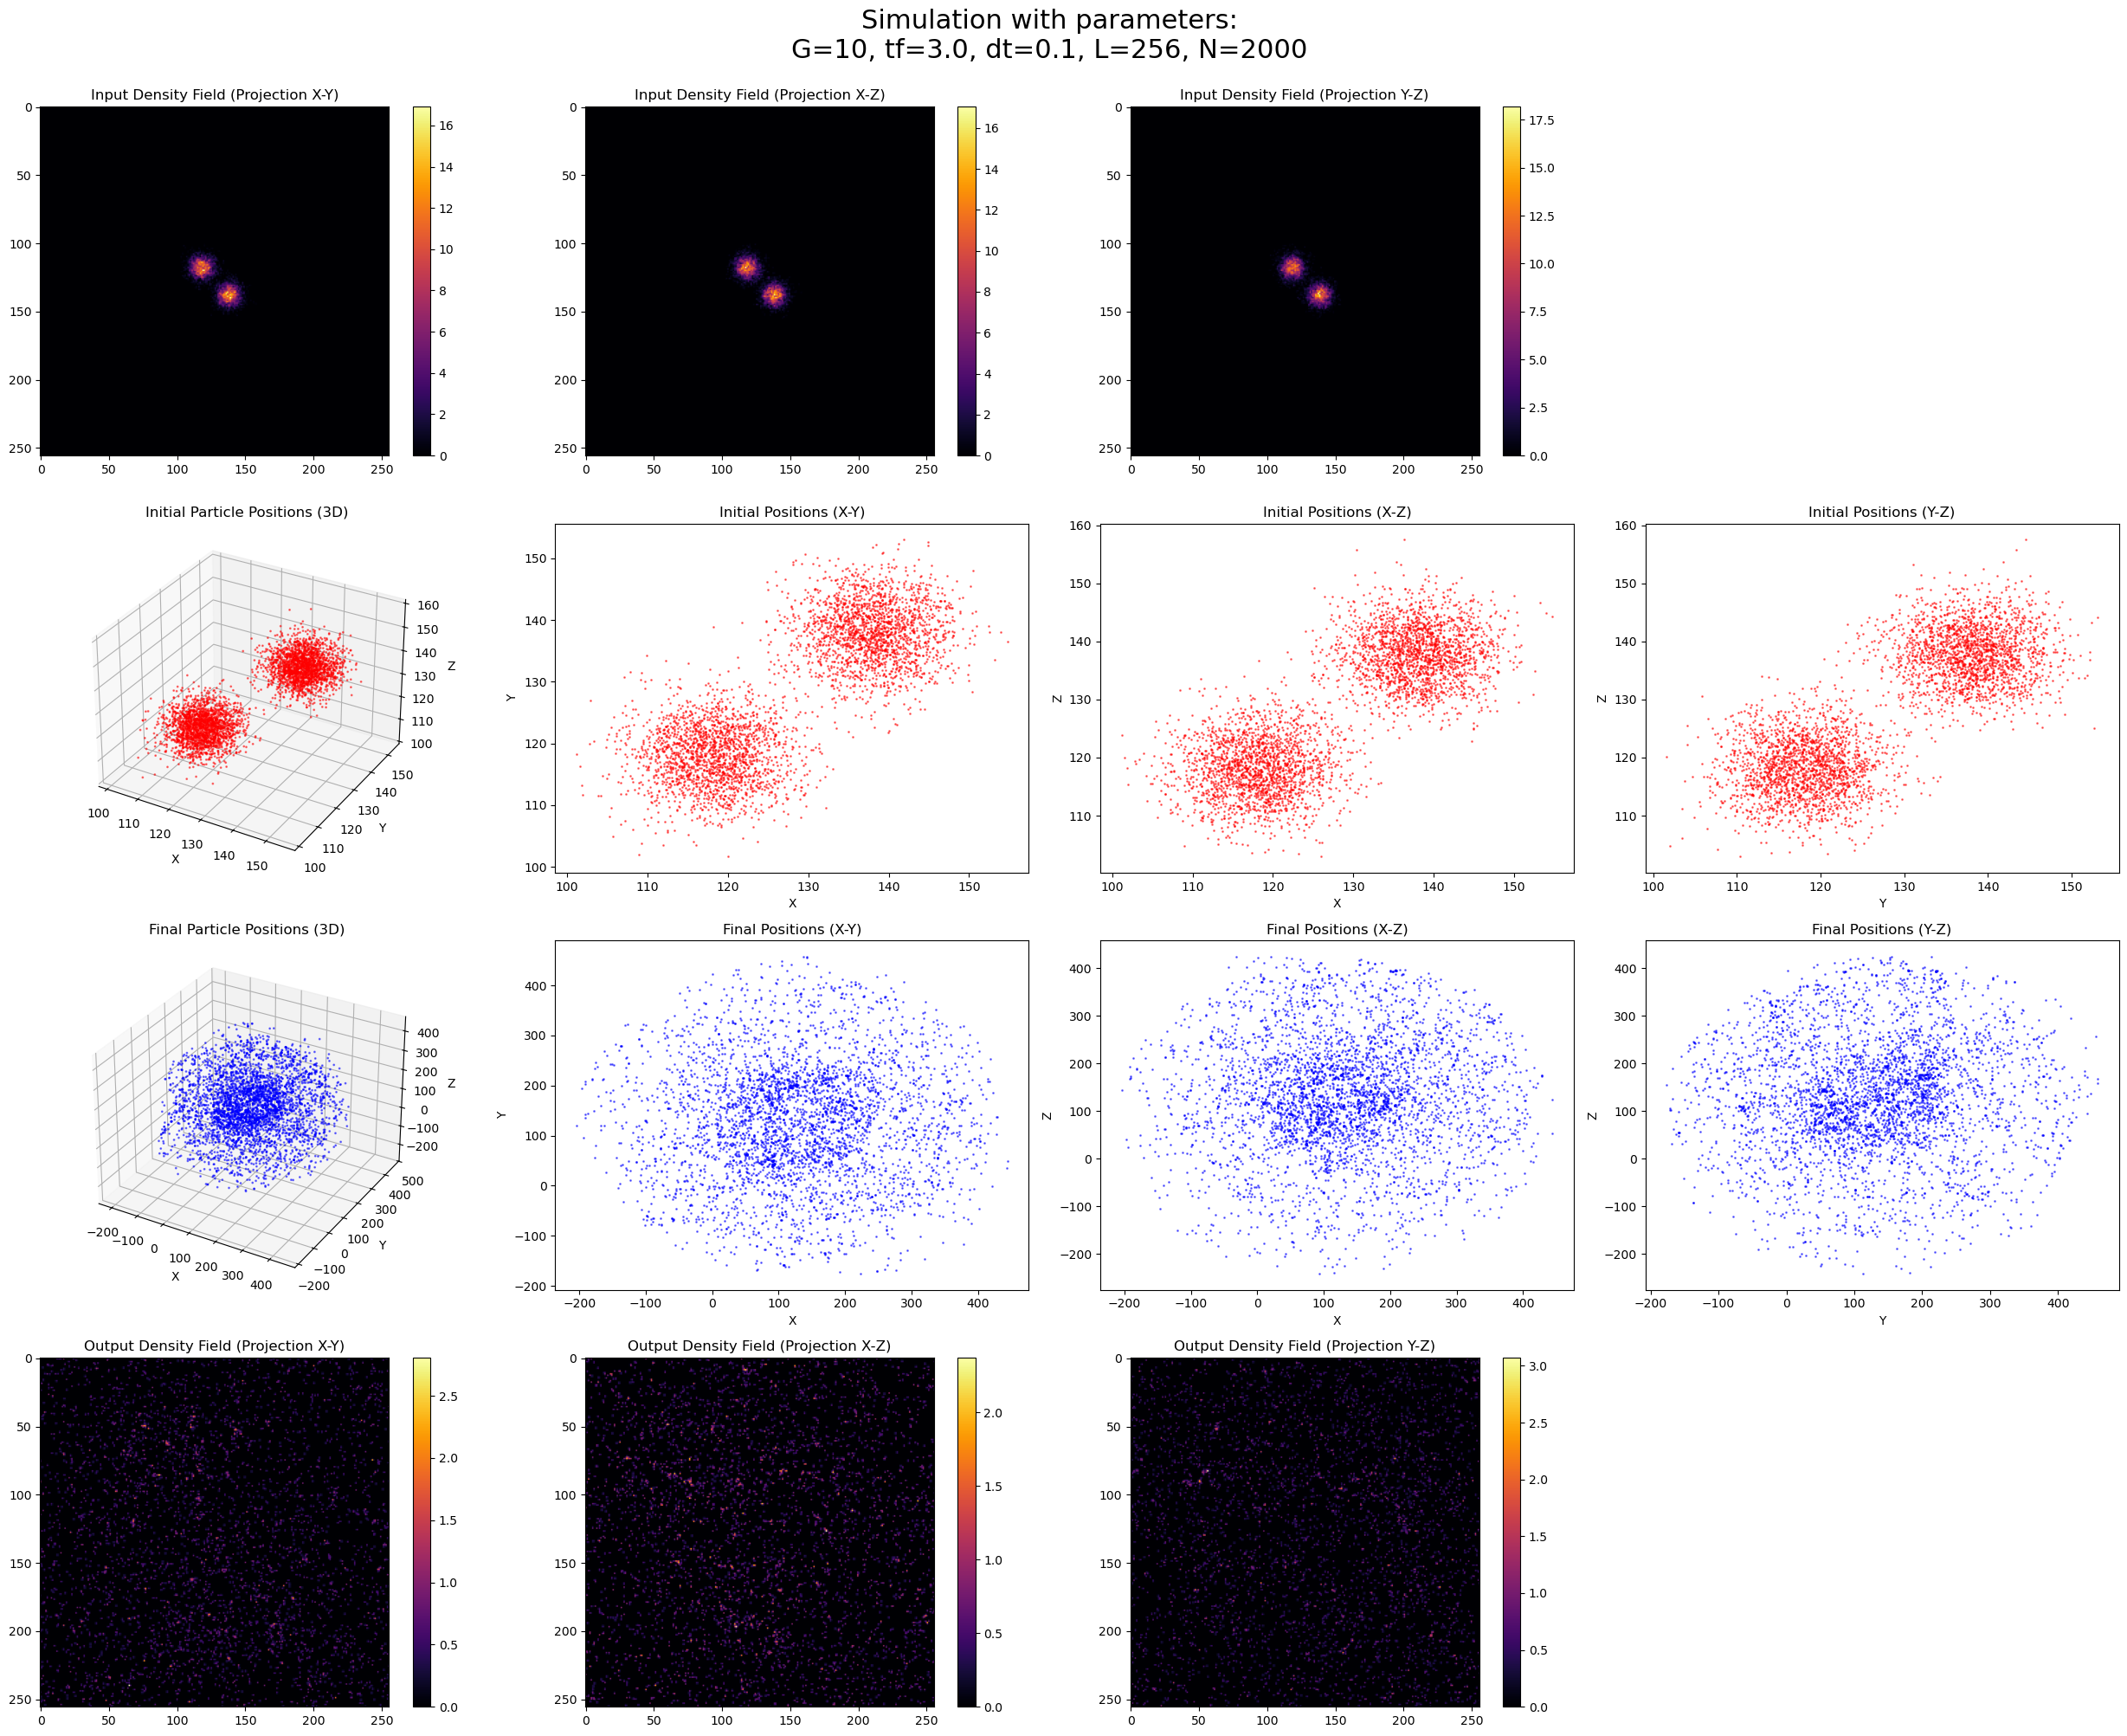

In [67]:
plt.show(plot_density_fields_and_positions(G, tf=t_f, dt=dt, length=length, n_part=n_part,
                                  input_field=input_field, init_pos=init_pos, final_pos=final_pos, output_field=output_field))

In [ ]:
plot_all_timesteps(sol, length=length, G=G, tf=t_f, dt=dt, n_part=n_part, skip=skip)

(<Figure size 2400x20000 with 250 Axes>,
 array([[<Axes: title={'center': 't=0.00  (XY)'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 't=0.00  (XZ)'}, xlabel='X', ylabel='Z'>,
         <Axes: title={'center': 't=0.00  (YZ)'}, xlabel='Y', ylabel='Z'>,
         <Axes: title={'center': 'Σ ρ(x,y)'}>],
        [<Axes: title={'center': 't=0.06  (XY)'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 't=0.06  (XZ)'}, xlabel='X', ylabel='Z'>,
         <Axes: title={'center': 't=0.06  (YZ)'}, xlabel='Y', ylabel='Z'>,
         <Axes: title={'center': 'Σ ρ(x,y)'}>],
        [<Axes: title={'center': 't=0.12  (XY)'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 't=0.12  (XZ)'}, xlabel='X', ylabel='Z'>,
         <Axes: title={'center': 't=0.12  (YZ)'}, xlabel='Y', ylabel='Z'>,
         <Axes: title={'center': 'Σ ρ(x,y)'}>],
        [<Axes: title={'center': 't=0.18  (XY)'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 't=0.18  (XZ)'}, xlabel='X', yla

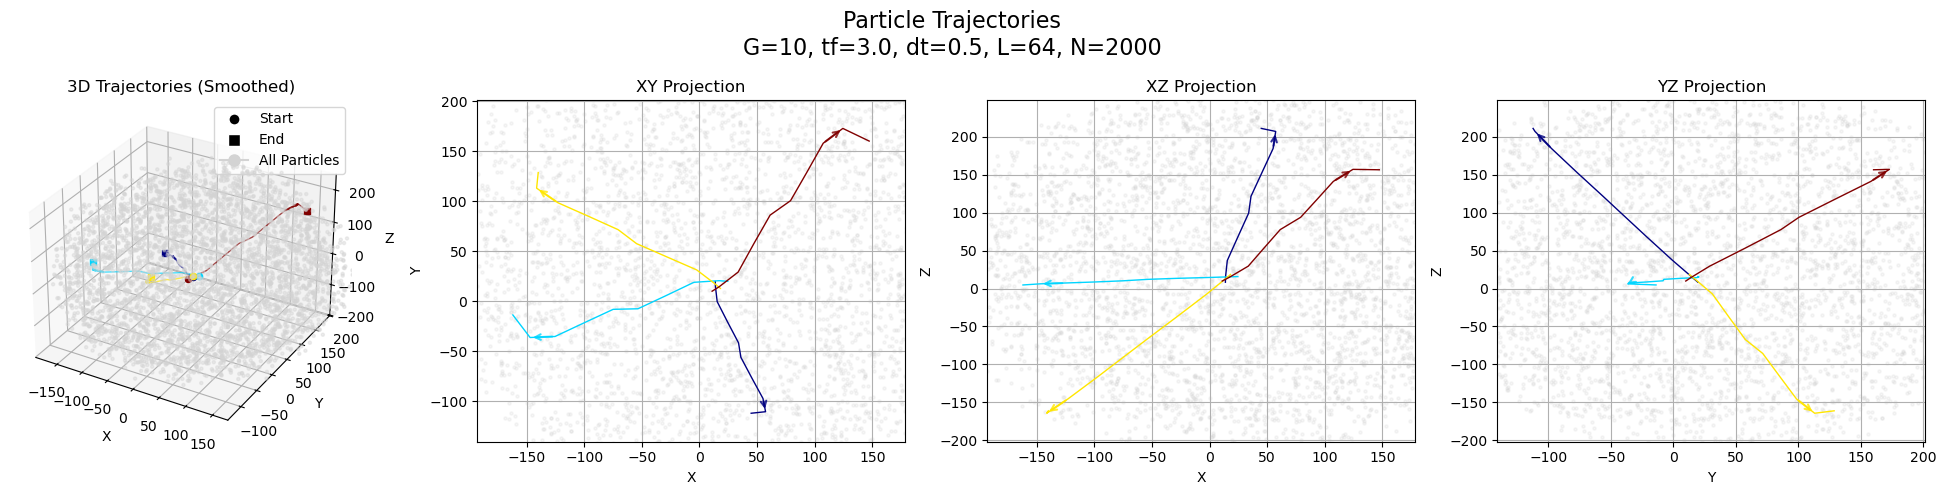

In [142]:
# Example usage:
particle_indices = np.random.choice(np.shape(sol.ys)[2], 4, replace=False)  # Randomly select 10 particles

# Example usage:
fig = plot_trajectories(sol, G=G, tf=t_f, dt=dt, length=length, n_part=n_part, particle_indices=particle_indices, smooth_window=3, title="Particle Trajectories")
plt.show()

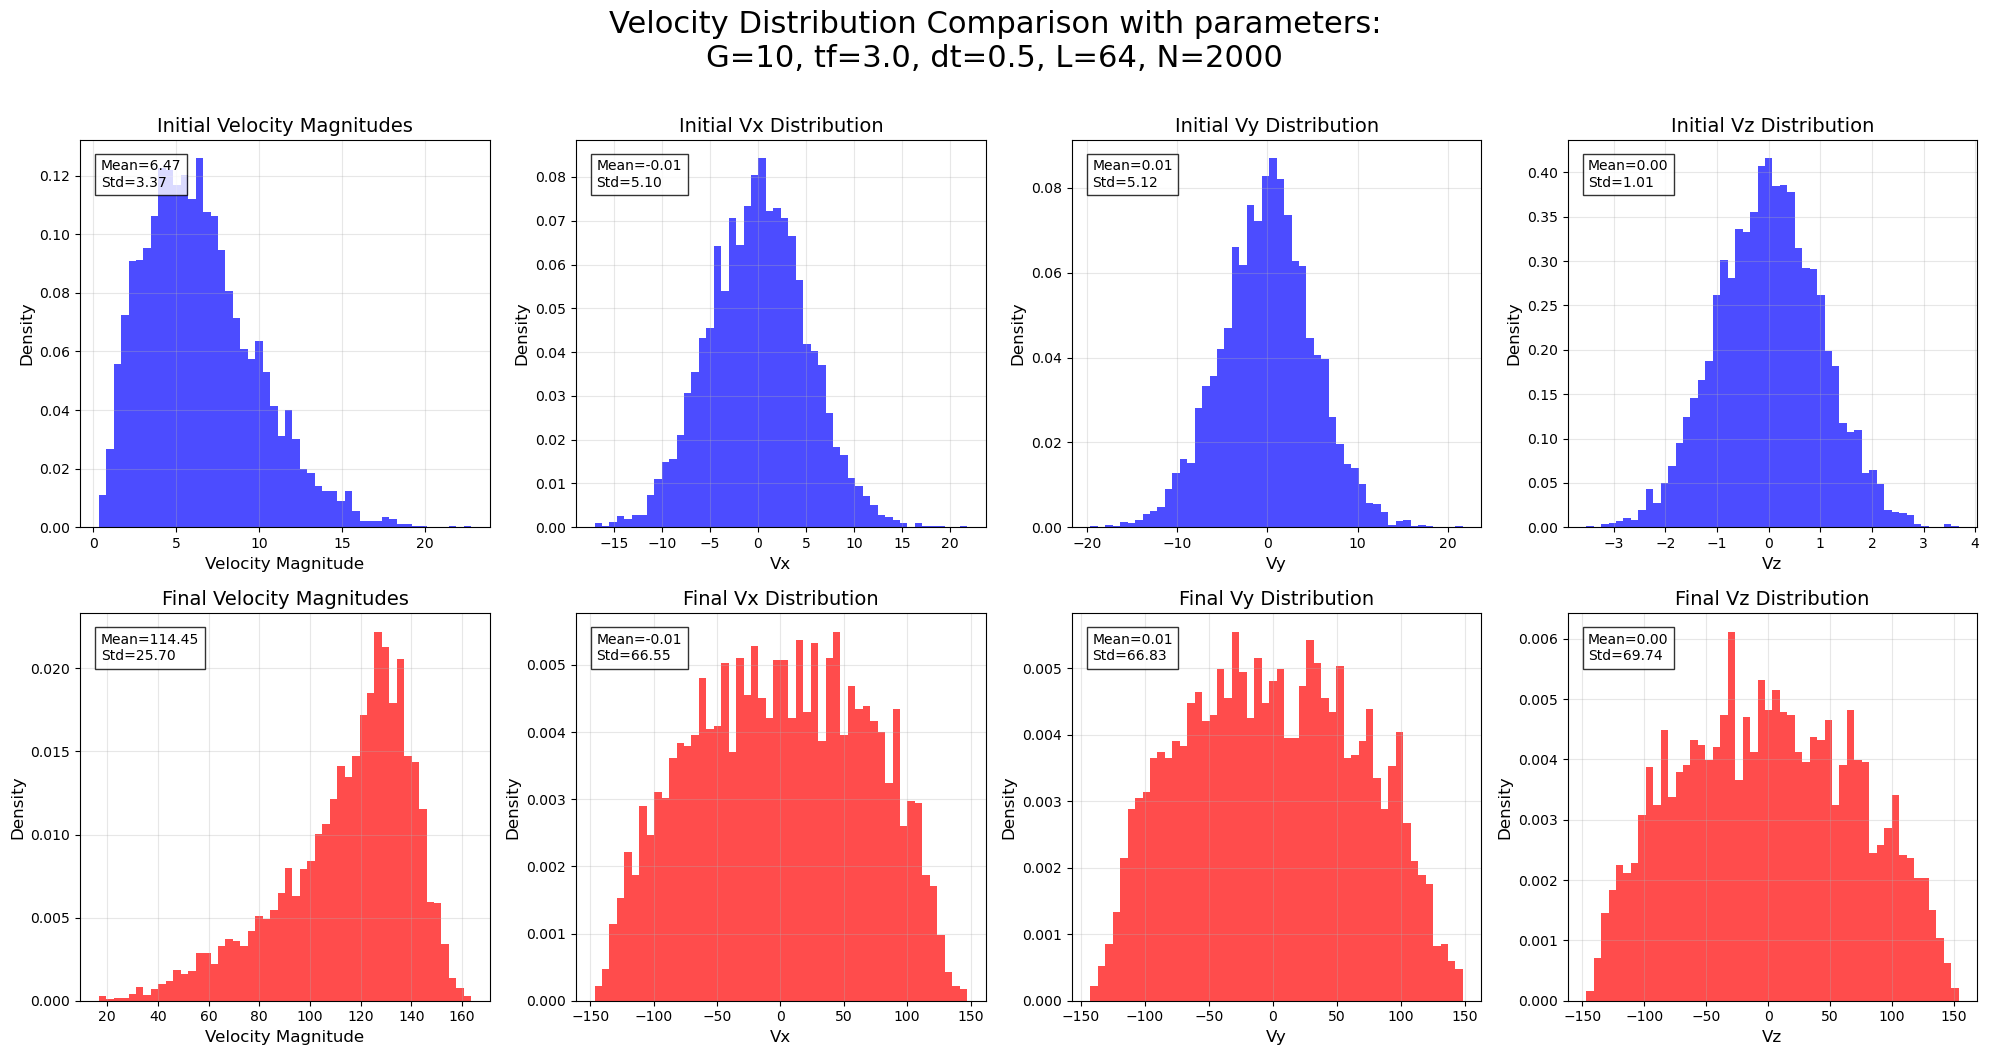

(<Figure size 2000x1000 with 8 Axes>,
 array([[<Axes: title={'center': 'Initial Velocity Magnitudes'}, xlabel='Velocity Magnitude', ylabel='Density'>,
         <Axes: title={'center': 'Initial Vx Distribution'}, xlabel='Vx', ylabel='Density'>,
         <Axes: title={'center': 'Initial Vy Distribution'}, xlabel='Vy', ylabel='Density'>,
         <Axes: title={'center': 'Initial Vz Distribution'}, xlabel='Vz', ylabel='Density'>],
        [<Axes: title={'center': 'Final Velocity Magnitudes'}, xlabel='Velocity Magnitude', ylabel='Density'>,
         <Axes: title={'center': 'Final Vx Distribution'}, xlabel='Vx', ylabel='Density'>,
         <Axes: title={'center': 'Final Vy Distribution'}, xlabel='Vy', ylabel='Density'>,
         <Axes: title={'center': 'Final Vz Distribution'}, xlabel='Vz', ylabel='Density'>]],
       dtype=object))

In [143]:
plot_velocity_distributions(sol, G=G, tf=t_f, dt=dt, length=length, n_part=n_part)

In [148]:
center_final = final_pos.mean(axis=0)
print(center_final)

[30.145111 30.004217 30.005169]


## Playground for simulations running

### Fixed settings

In [144]:
# Fixed parameters for the multiple simulations
length = 64

# Define system parameters
n_part = 1000  # number of particles
theta_1 = [5.0, 20.0, 1.0] 
theta_2 = [5.0, 40.0, 1.0] 

# Initialize positions and velocities 
init_pos_1 = np.random.randn(n_part, 3) * theta_1[0] + theta_1[1] # pos = [number of particles, 3]
init_vel_1 = np.random.randn(n_part, 3) * theta_1[2]
init_pos_2 = np.random.randn(n_part, 3) * theta_2[0] + theta_2[1]
init_vel_2 = np.random.randn(n_part, 3) * theta_2[2]
init_pos = np.concatenate([init_pos_1, init_pos_2], axis=0)
init_vel = np.concatenate([init_vel_1, init_vel_2], axis=0)

y0 = jnp.stack([init_pos, init_vel], axis=0)
input_field = cic_paint(jnp.zeros((length, length, length)), init_pos)

### Playground with one simulation 

In [145]:
# Parameters 
G = 30
softening = 1e-4
t_f = 1
dt = 0.1
ts = jnp.linspace(0, t_f, 10)
skip = ts.shape[0] // 10

In [146]:
term = ODETerm(make_diffrax_ode(softening=softening, G=G, length=length))
solver = LeapfrogMidpoint()
sol = diffeqsolve(term, solver, t0=0, t1=t_f, dt0=dt, y0=y0, saveat = SaveAt(ts=ts))

# Final positions
final_pos = sol.ys[-1, 0]     # positions at final time (t=1)
output_field = cic_paint(jnp.zeros((length, length, length)), final_pos)

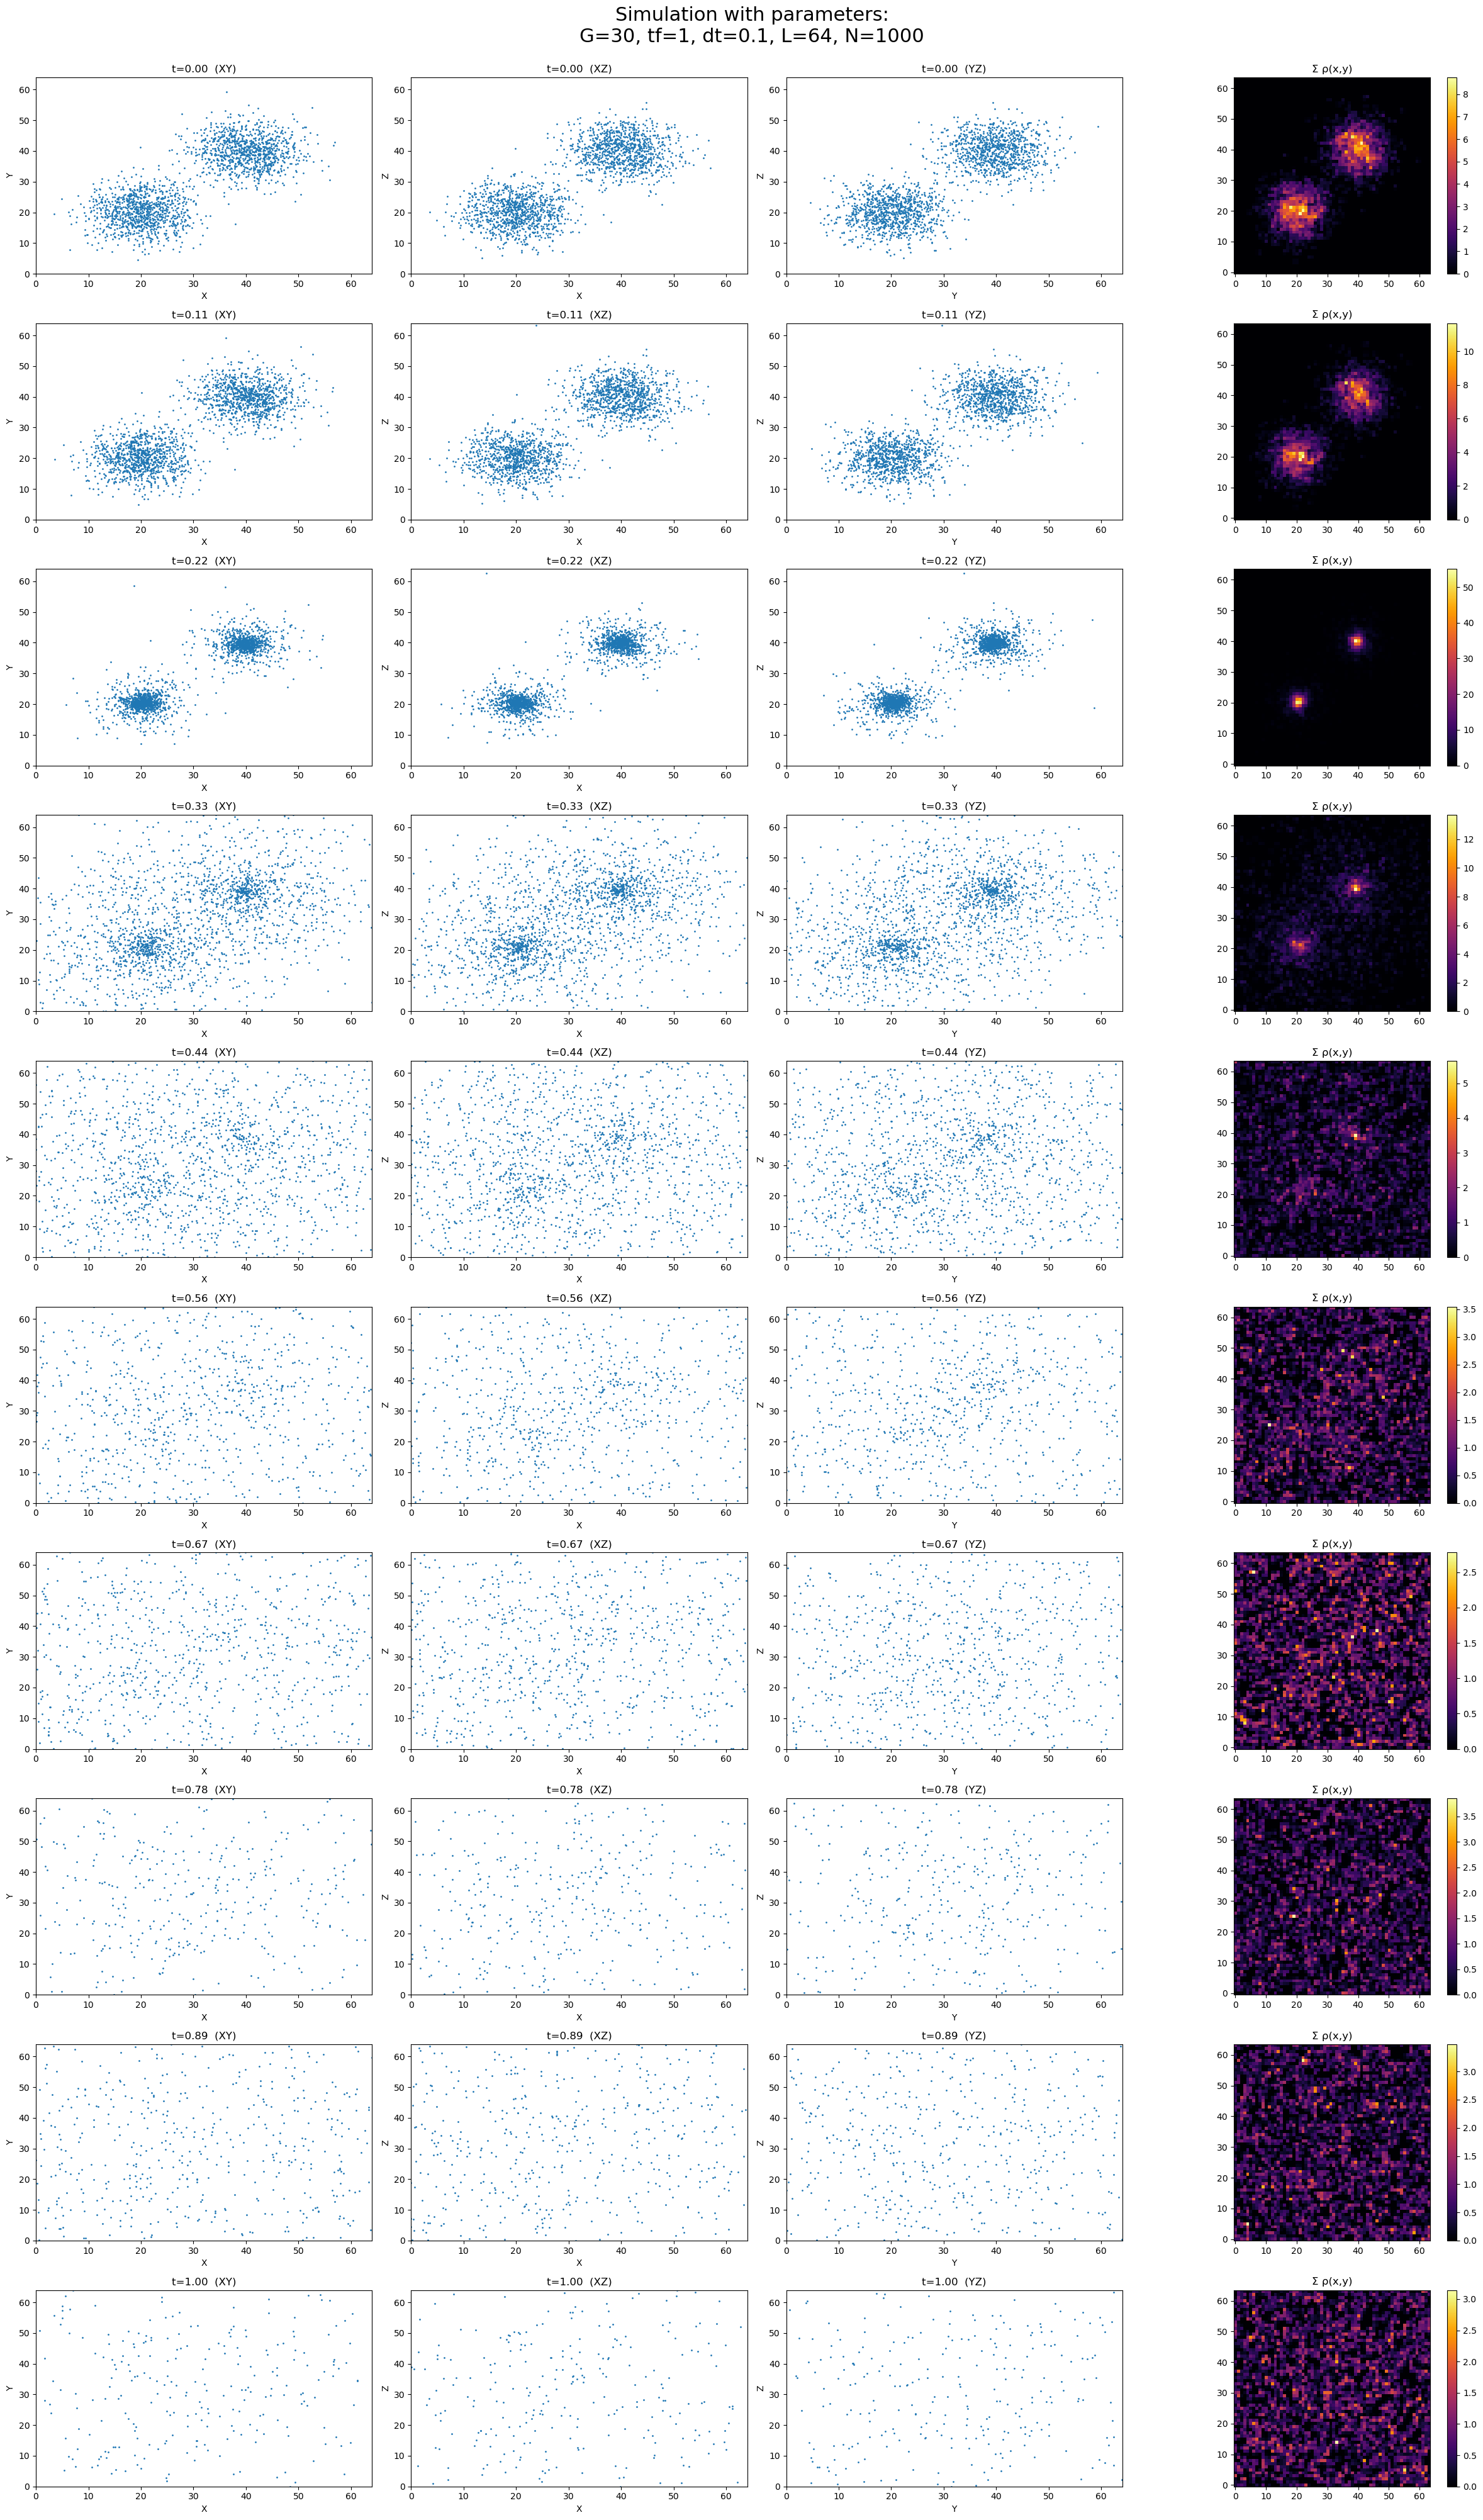

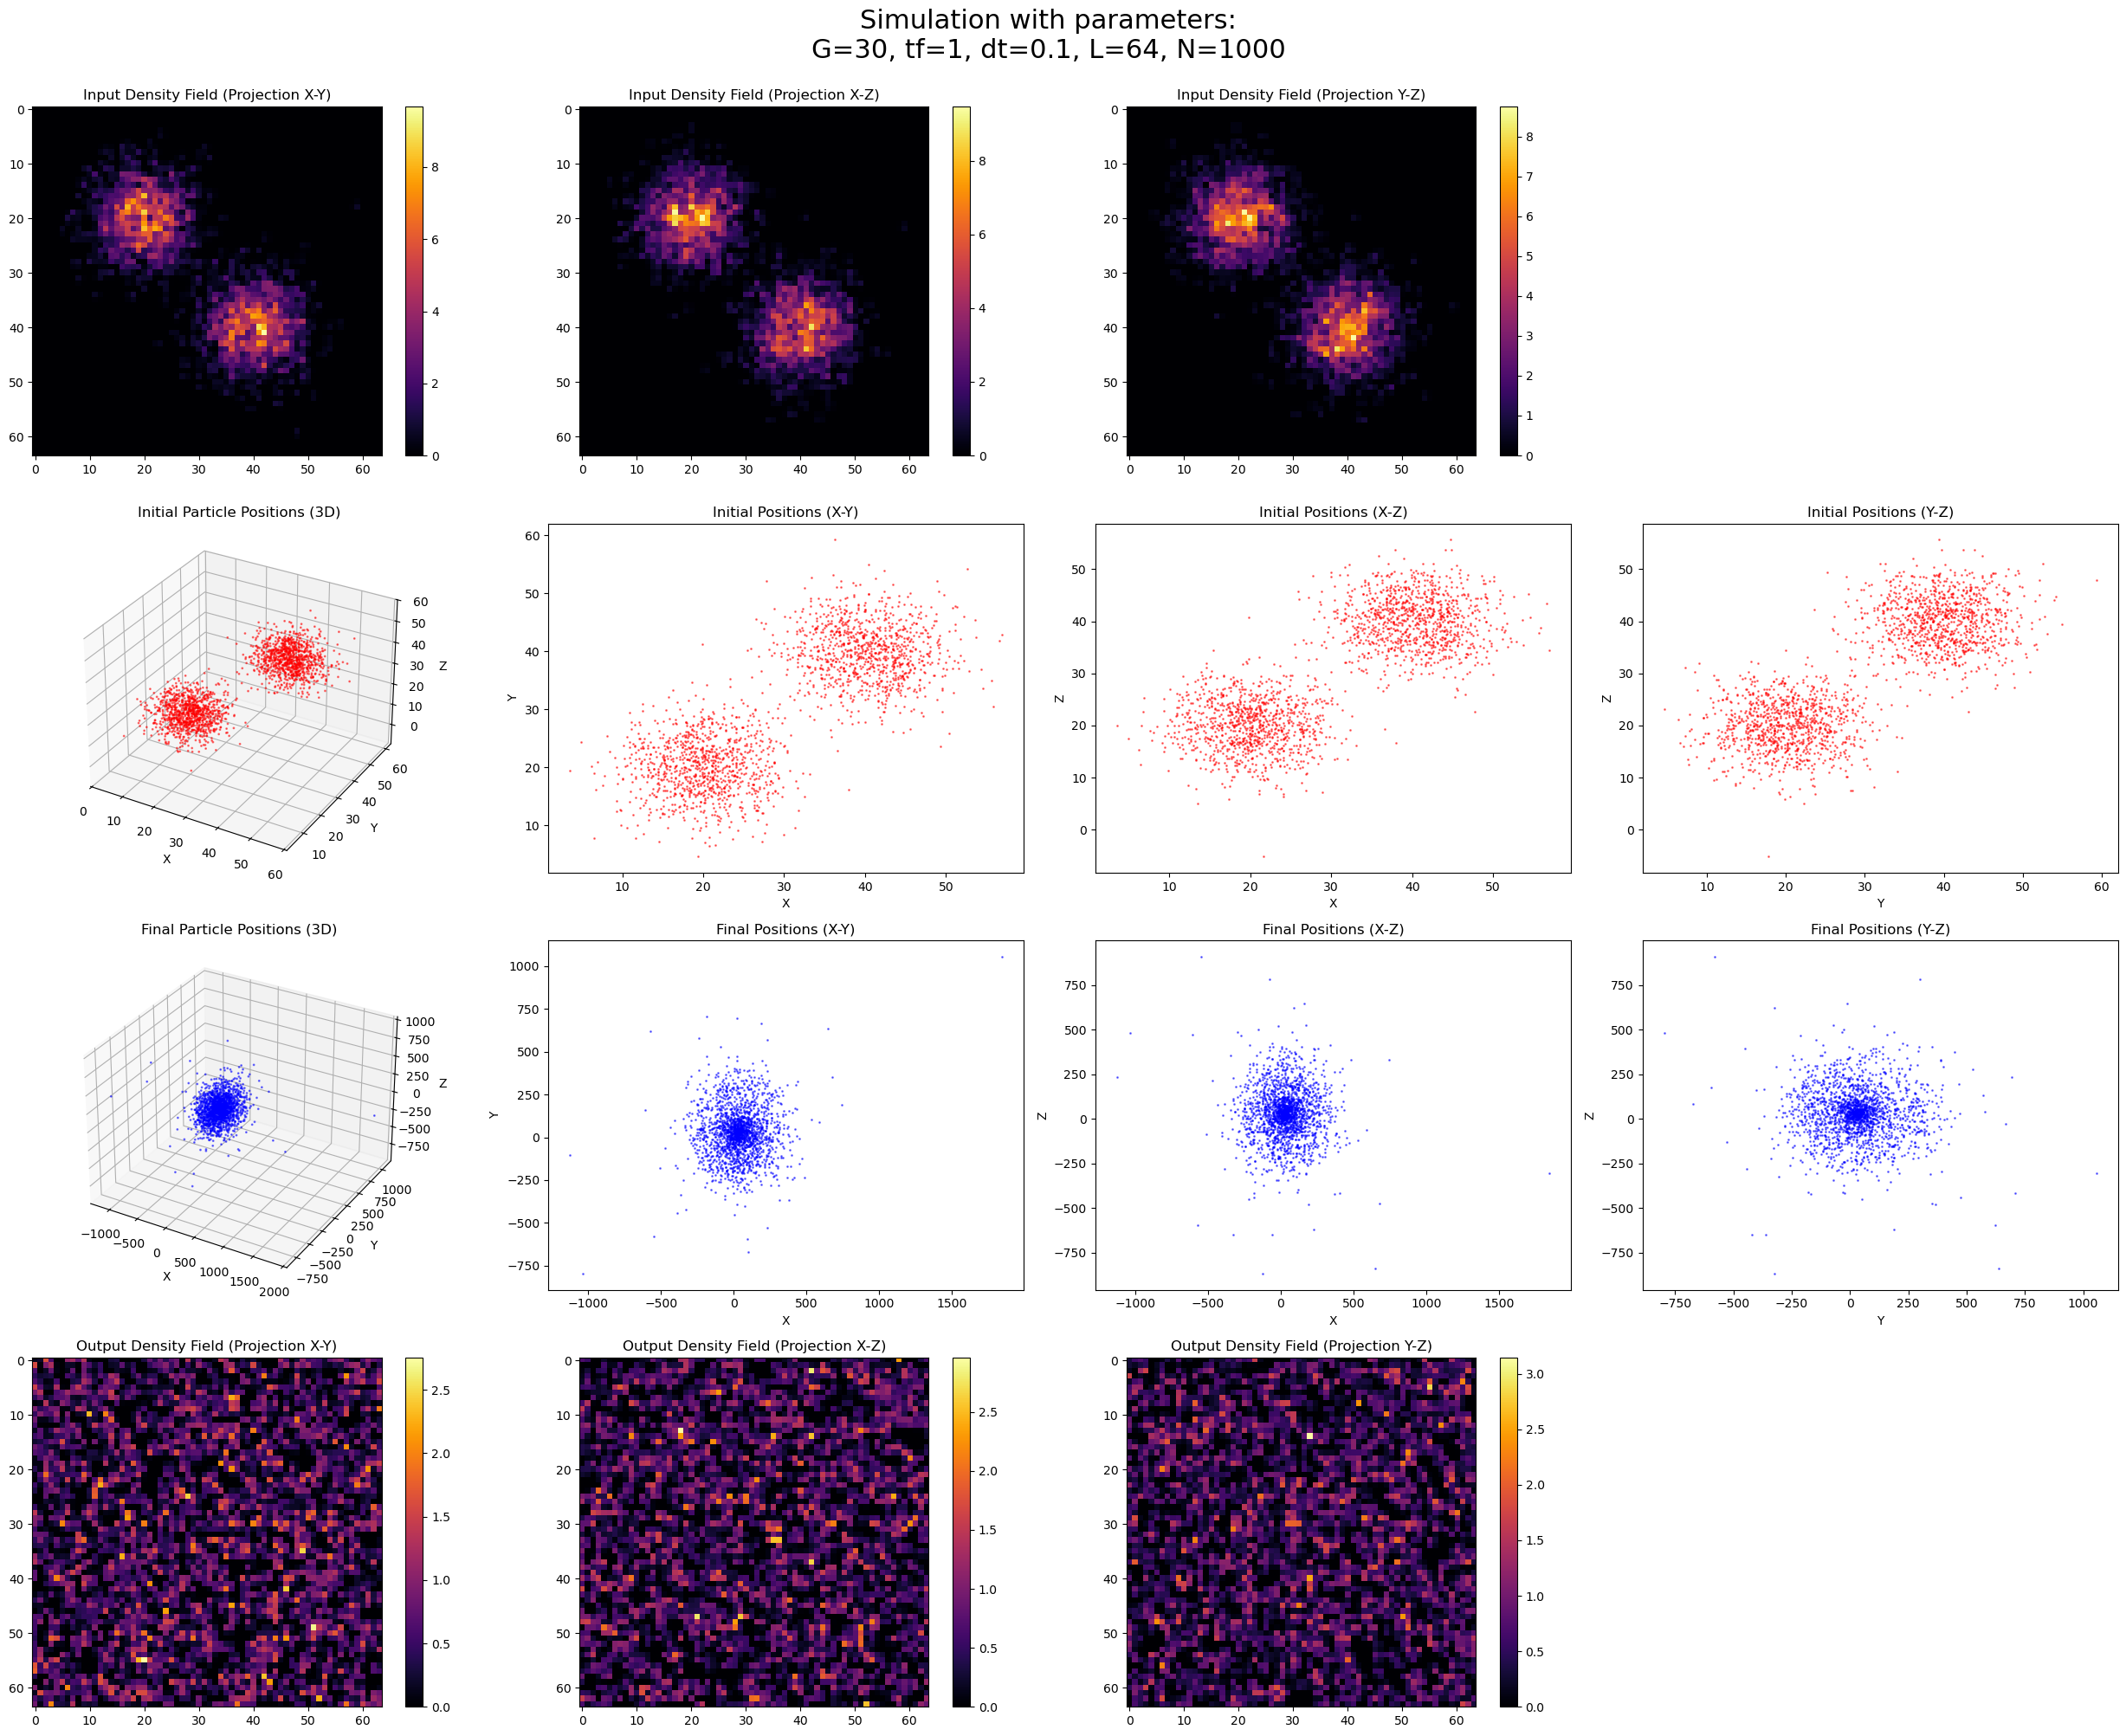

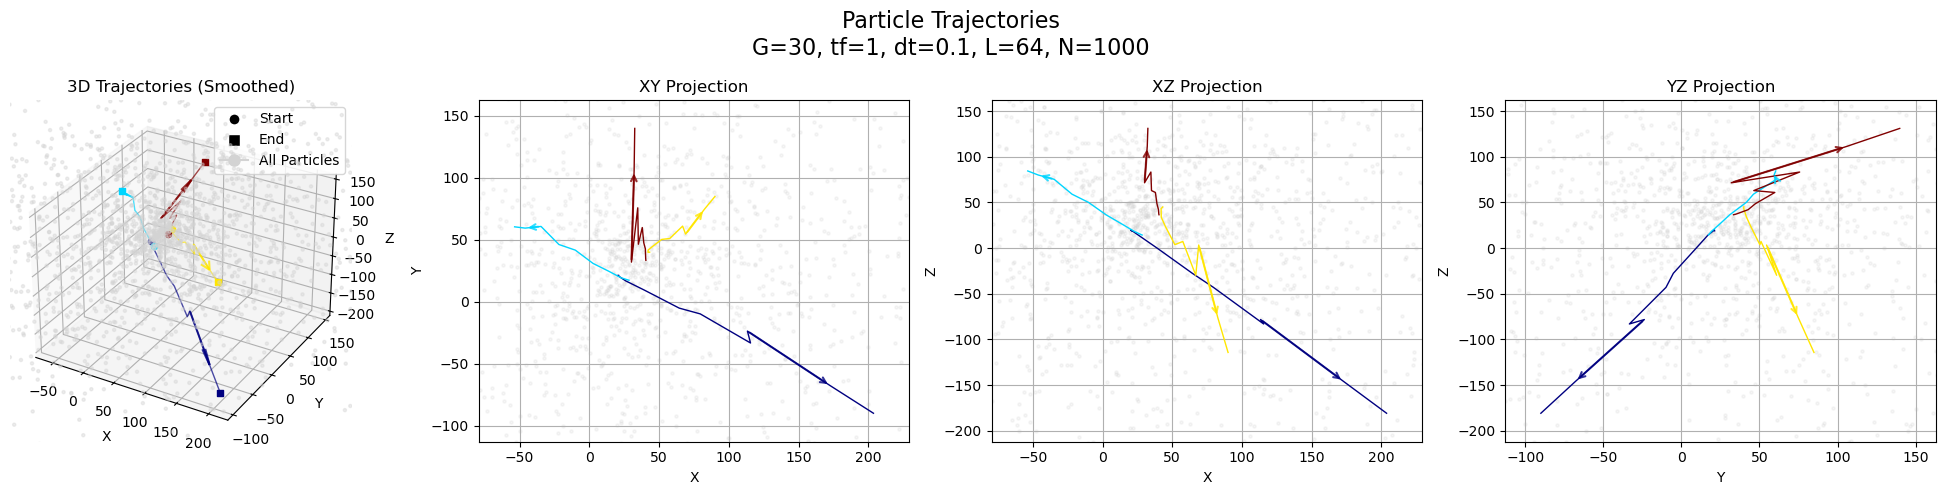

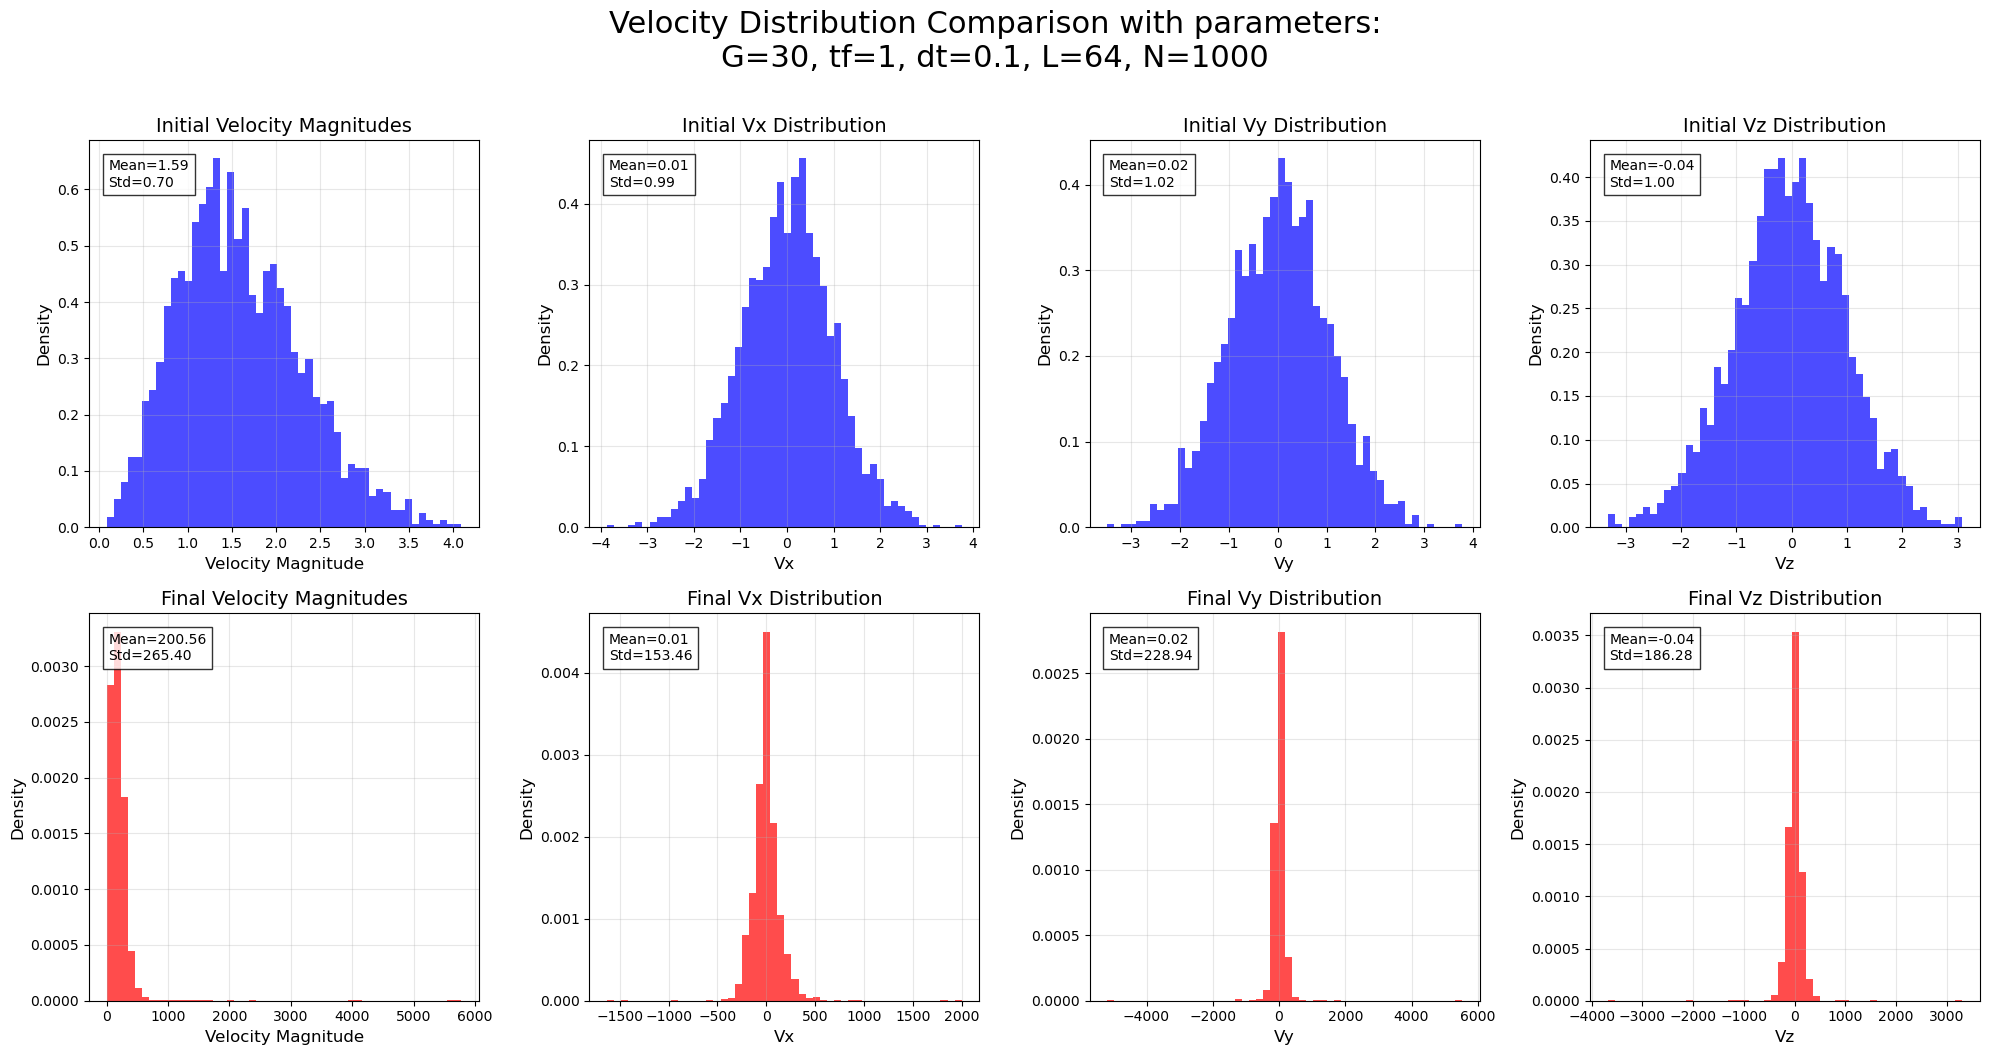

In [147]:
fig_steps, axes_steps = plot_all_timesteps(sol, G=G, tf=t_f, dt=dt, n_part=n_part, boxL=length, skip=skip)
fig_densities = plot_density_fields_and_positions(G, tf=t_f, dt=dt, length=length, n_part=n_part, 
                                    input_field=input_field, init_pos=init_pos, final_pos=final_pos, output_field=output_field)

particle_indices = np.random.choice(np.shape(sol.ys)[2], 4, replace=False)  # Randomly select 10 particles
fig_trajectories = plot_trajectories(sol, G=G, tf=t_f, dt=dt, length=length, n_part=n_part, particle_indices=particle_indices, smooth_window=3, title="Particle Trajectories")
fig_velocity_distributions, axes_vel = plot_velocity_distributions(sol, G=G, tf=t_f, dt=dt, length=length, n_part=n_part)
#plt.show()

In [33]:
import os

# Create a function to save figures with parameter-based naming
def save_simulation_results(G, softening, t_f, dt, n_part, fig_list, base_dir="notebooks/nbody_sim_results"):
    # Create a folder name based on parameters
    folder_name = f"G{G}_soft{softening}_tf{t_f}_dt{dt}_N{n_part}"
    full_path = os.path.join(base_dir, folder_name)
    
    # Create directory if it doesn't exist
    os.makedirs(full_path, exist_ok=True)
    
    # Save each figure with appropriate name
    for i, (fig, name) in enumerate(fig_list):
        filename = os.path.join(full_path, f"{name}.png")
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename}")
    
    # Save parameter information in a text file
    with open(os.path.join(full_path, "parameters.txt"), "w") as f:
        f.write(f"G = {G}\n")
        f.write(f"Softening = {softening}\n")
        f.write(f"Final time = {t_f}\n")
        f.write(f"Time step = {dt}\n")
        f.write(f"Number of particles = {n_part}\n")
        f.write(f"Initial position blobs: {theta_1}, {theta_2}\n")
    
    print(f"Simulation results saved to {full_path}")
    return full_path


In [34]:
fig_list = [
    (fig_densities, "density_fields"),
    (fig_steps, "timesteps"),
    (fig_trajectories, "trajectories"),
    (fig_velocity_distributions, "velocity_distributions")
]

# Save all figures
output_path = save_simulation_results(G, softening, t_f, dt, n_part*2, fig_list)

Saved Files/DiffNBody-main/output_nbody/G30_soft0.0001_tf1_dt0.1_N2000/density_fields.png
Saved Files/DiffNBody-main/output_nbody/G30_soft0.0001_tf1_dt0.1_N2000/timesteps.png
Saved Files/DiffNBody-main/output_nbody/G30_soft0.0001_tf1_dt0.1_N2000/trajectories.png
Saved Files/DiffNBody-main/output_nbody/G30_soft0.0001_tf1_dt0.1_N2000/velocity_distributions.png
Simulation results saved to Files/DiffNBody-main/output_nbody/G30_soft0.0001_tf1_dt0.1_N2000


### Multiple simulations

In [ ]:
def run_simulation(G, softening, t_f, dt):
    ts = jnp.linspace(0, t_f, 10)
    skip = ts.shape[0] // 10
    print(f"Running simulation with G={G}, softening={softening}, t_f={t_f}, dt={dt}")
    term = ODETerm(make_diffrax_ode(softening=softening, G=G, length=length))
    solver = LeapfrogMidpoint()
    sol = diffeqsolve(term, solver, t0=0, t1=t_f, dt0=dt, y0=y0, saveat = SaveAt(ts=ts))
    final_pos = sol.ys[-1, 0]     # positions at final time (t=1)
    output_field = cic_paint(jnp.zeros((length, length, length)), final_pos)
    fig_steps, axes_steps = plot_all_timesteps(sol, G=G, tf=t_f, dt=dt, n_part=n_part, boxL=length, skip=skip)
    fig_densities = plot_density_fields_and_positions(G, tf=t_f, dt=dt, length=length, n_part=n_part, 
                                        input_field=input_field, init_pos=init_pos, final_pos=final_pos, output_field=output_field)
    particle_indices = np.random.choice(np.shape(sol.ys)[2], 4, replace=False)  # Randomly select 10 particles
    fig_trajectories = plot_trajectories(sol, G=G, tf=t_f, dt=dt, length=length, n_part=n_part, particle_indices=particle_indices, smooth_window=3, title="Particle Trajectories")
    fig_velocity_distributions, axes_vel = plot_velocity_distributions(sol, G=G, tf=t_f, dt=dt, length=length, n_part=n_part)
    save_simulation_results(G, softening, t_f, dt, n_part*2, fig_list)
    return

In [ ]:
parameter_sets = [
    {'G': 30, 'softening': 1e-4, 't_f': 1, 'dt': 0.1},
    {'G': 40, 'softening': 1e-3, 't_f': 2, 'dt': 0.05},
    # Add more parameter sets as needed
]

In [ ]:
for params in parameter_sets:
    result = run_simulation(**params)
    results.append(result)

## One central mass test case

In [35]:
# ------------------------------------------------------------------
# 1.   Forces
# ------------------------------------------------------------------
@jax.jit
def pairwise_forces(pos, G, softening, boxL):
    """As in your snippet: mutual forces with minimal-image B.C."""
    dx = pos[:, None, :] - pos[None, :, :]           # (N,N,3)
    dx = dx - boxL * jnp.round(dx / boxL)
    r2 = jnp.sum(dx**2, axis=-1) + softening**2
    inv_r3 = jnp.where(jnp.eye(pos.shape[0]), 0., r2**-1.5)
    F = -G * jnp.einsum('ij,ijc->ic', inv_r3, dx)    # (N,3)
    return F                                         # accel

@jax.jit
def central_force(pos, M_star, G, softening, boxL, center=jnp.zeros(3)):
    """Acceleration from a fixed point-mass at `center` (default: origin)."""
    dx = pos - center
    dx = dx - boxL * jnp.round(dx / boxL)            # keep periodic if you wish
    r2 = jnp.sum(dx**2, axis=-1) + softening**2
    inv_r3 = r2**-1.5
    return G * M_star * dx * inv_r3[:, None]        # (N,3)

# ------------------------------------------------------------------
# 2.   ODE builder
# ------------------------------------------------------------------
def make_diffrax_ode(G=1.0,
                     softening=1e-1,
                     boxL=256,
                     M_star=1e4,
                     include_self_gravity=True,
                     center=jnp.zeros(3)):

    def nbody_ode(t, state, args=None):
        pos, vel = state                             # pos,vel  both (N,3)

        # --- accelerations --------------------------------------------------
        acc = central_force(pos, M_star, G, softening, boxL, center)

        if include_self_gravity:
            acc += pairwise_forces(pos, G, softening, boxL)

        # --------------------------------------------------------------------
        dpos = vel                                   # ẋ = v
        dvel = acc                                   # v̇ = a
        return (dpos, dvel)                          # PyTree is fine for diffrax

    return nbody_ode


In [46]:
# ------------------------------------------------------------------
# Initial positions and velocities
# ------------------------------------------------------------------
n_part = 1_000
theta_1 = [5.0, 100.0, 1.0]
theta_2 = [5.0, 140.0, 1.0]

init_pos = np.concatenate([
    np.random.randn(n_part, 3) * theta_1[0] + theta_1[1],
    np.random.randn(n_part, 3) * theta_2[0] + theta_2[1]], axis=0)

init_vel = np.concatenate([
    np.random.randn(n_part, 3) * theta_1[2],
    np.random.randn(n_part, 3) * theta_2[2]], axis=0)

# Make them JAX arrays
init_pos = jnp.asarray(init_pos)
init_vel = jnp.asarray(init_vel)

# ------------------------------------------------------------------
# ODE solver and settings
# ------------------------------------------------------------------

length = 256
soft = 10**-1
G = 10.0
M_star = 1e5                    # (units: particle mass)
tf = 1
dt = 0.1

ode_fn  = make_diffrax_ode(G=G,
                           softening=soft,
                           boxL=length,
                           M_star=M_star,
                           include_self_gravity=True)   # <-- set to False for central mass potential only

term    = ODETerm(ode_fn)
solver  = LeapfrogMidpoint()

y0      = (init_pos, init_vel)   
ts = jnp.linspace(0, tf, 10)         # time grid for saving
skip = ts.shape[0] // 10
sol     = diffeqsolve(term, solver,
                      t0=0.0, t1=tf,
                      dt0=dt,
                      y0=y0,
                      saveat = SaveAt(ts=ts))

final_pos = sol.ys[1][0]         # sol.ys = (positions, velocities)
out_field = cic_paint(jnp.zeros((length,)*3), final_pos)


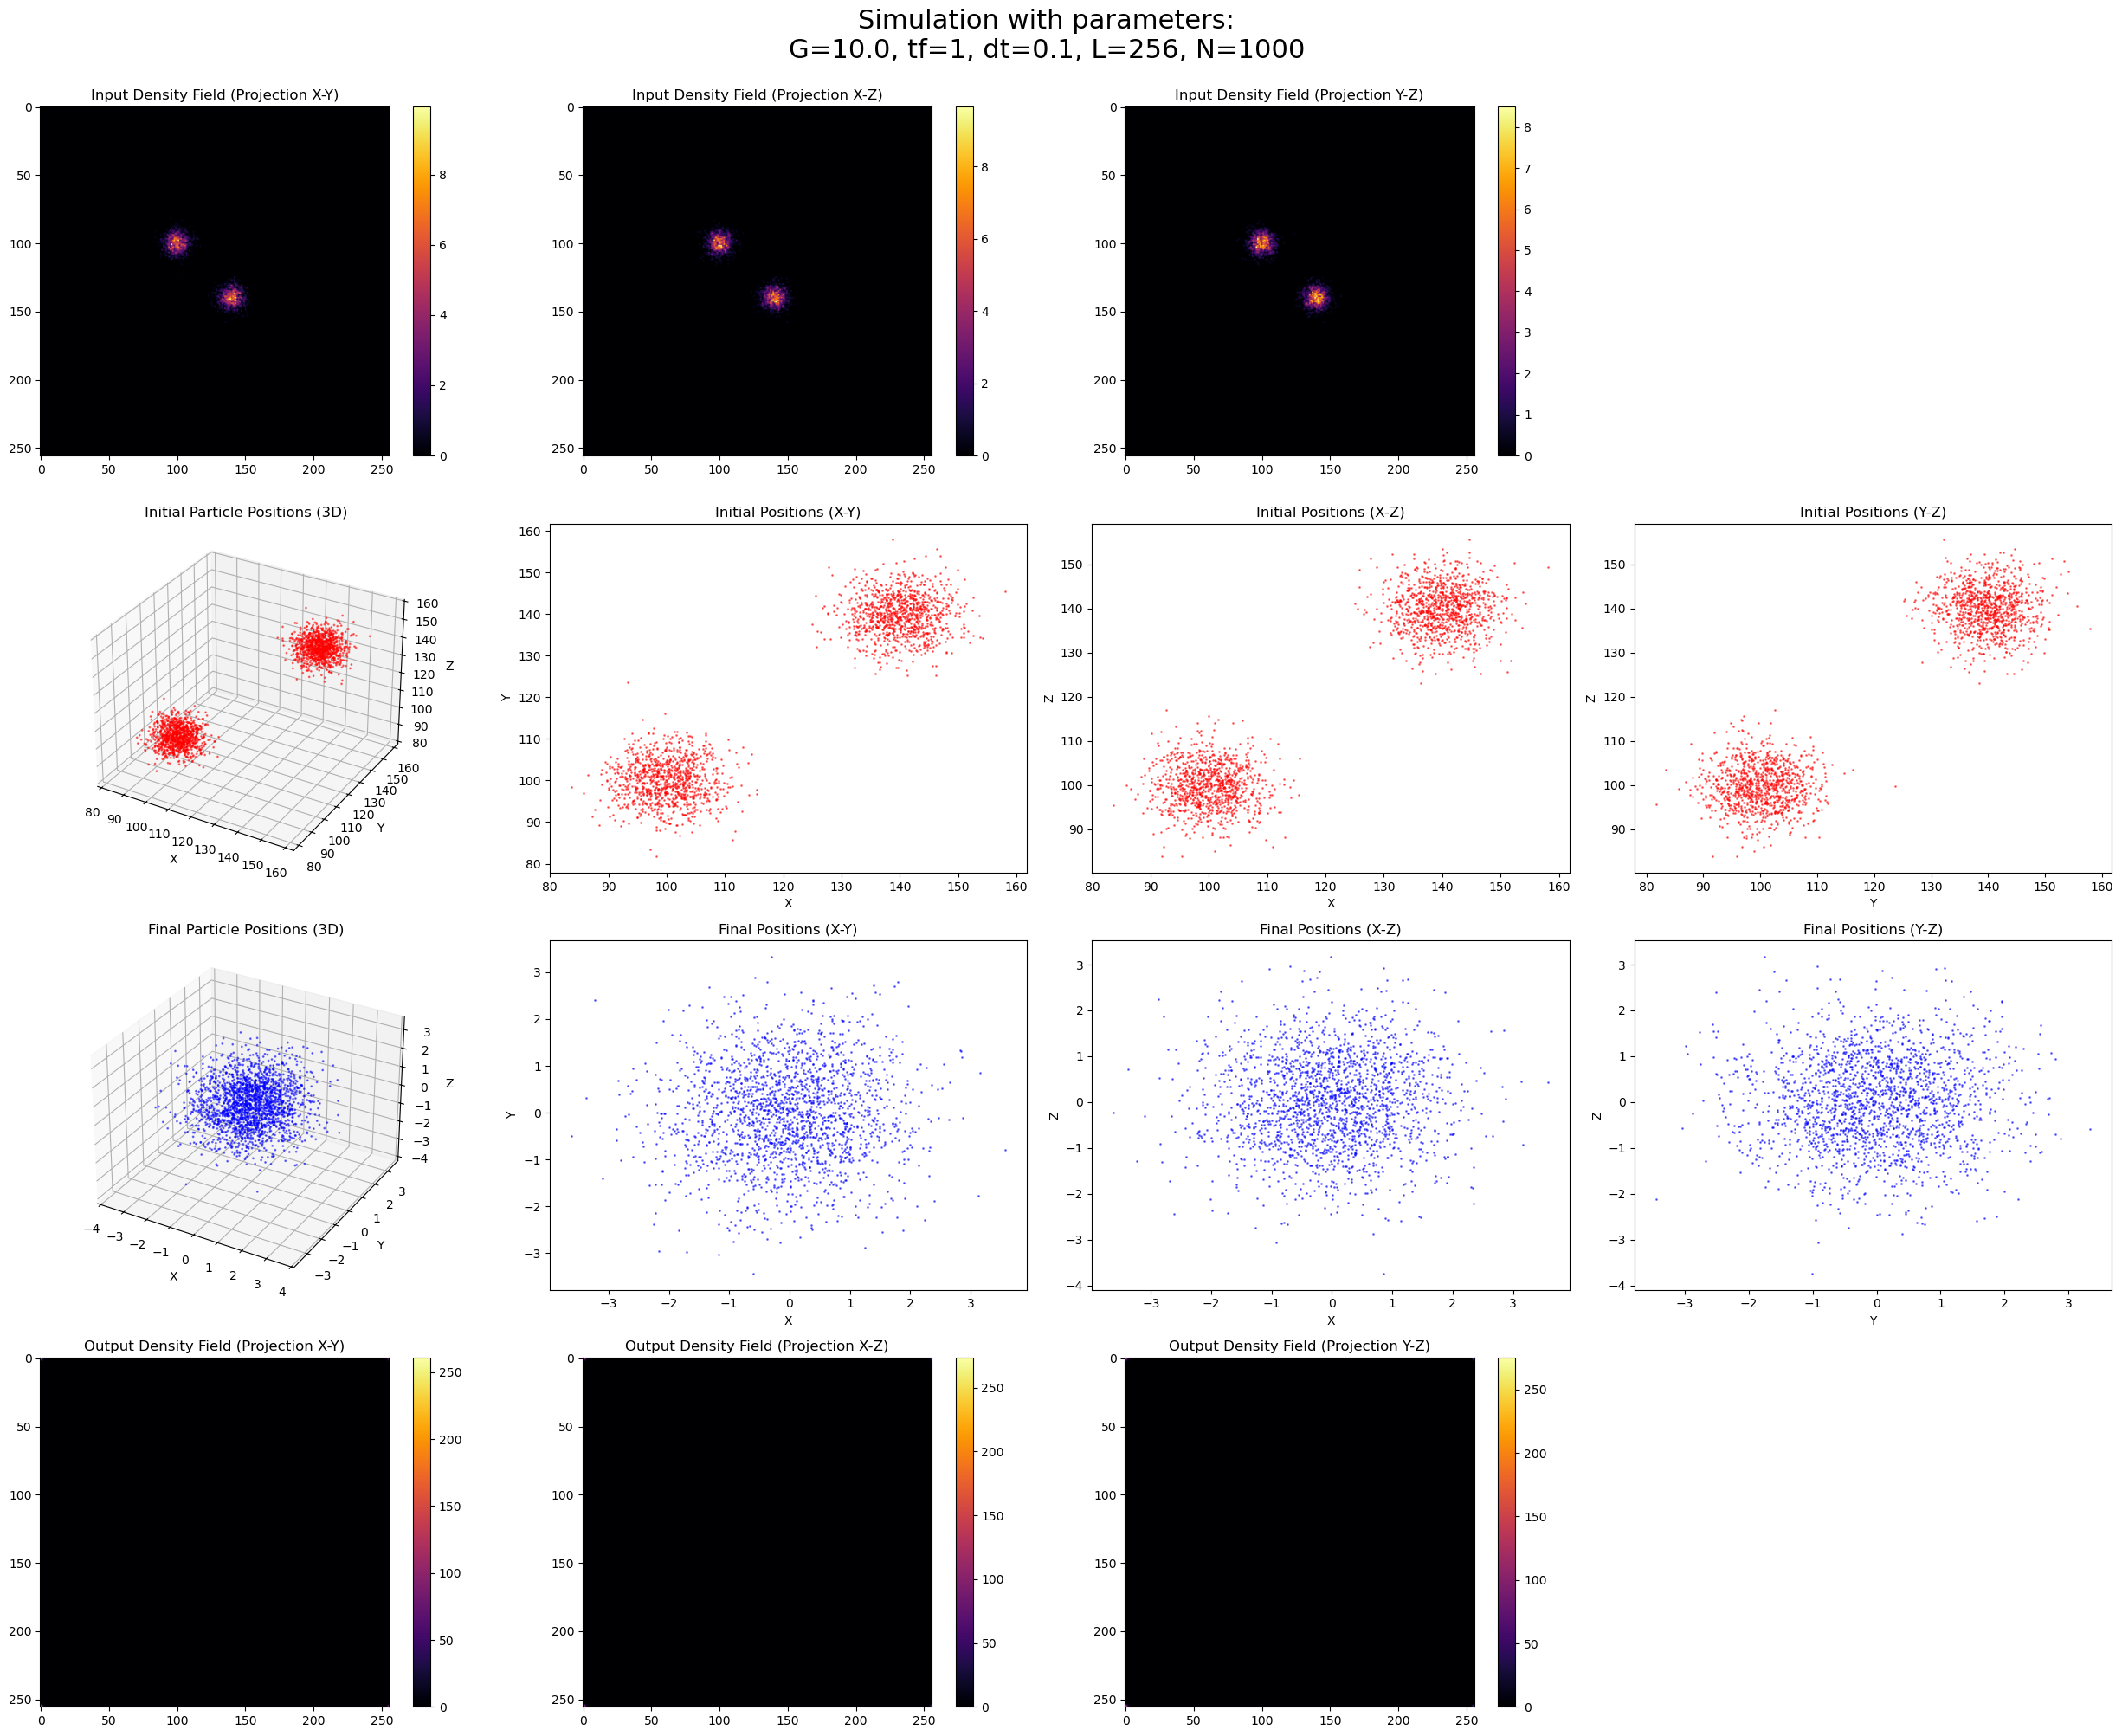

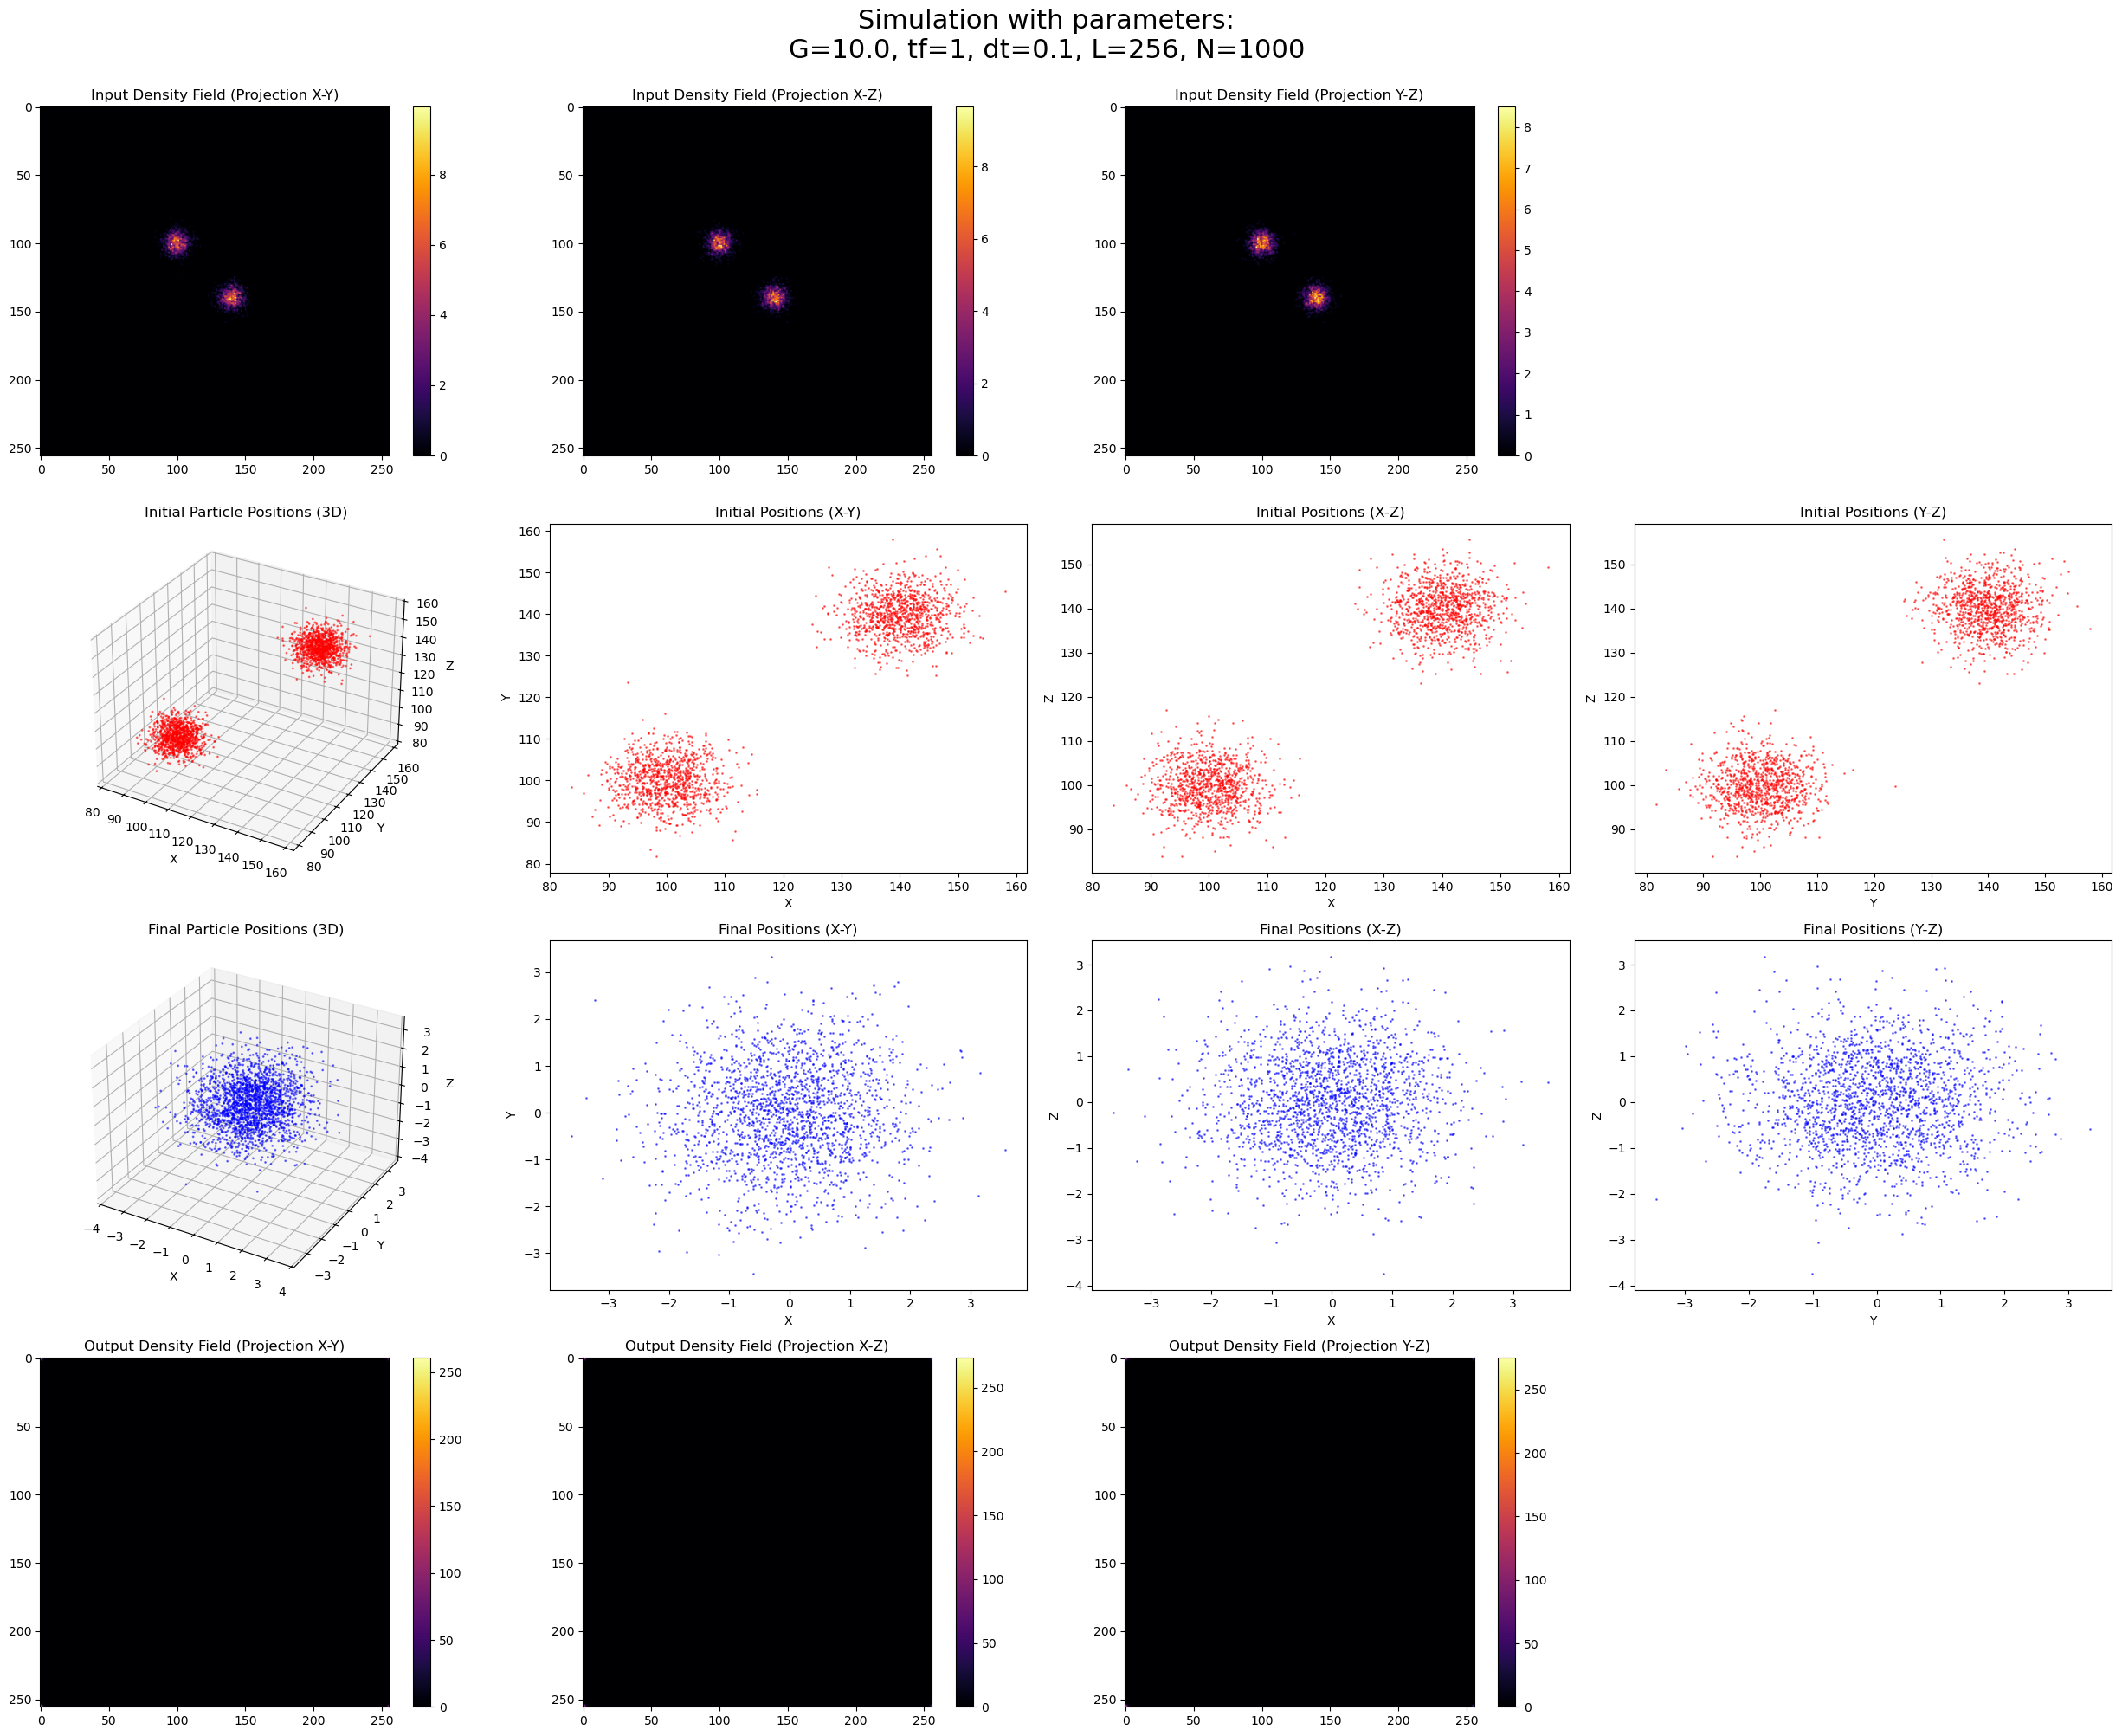

In [47]:
plot_density_fields_and_positions(G=G, tf=tf, dt=dt, length=length, n_part=n_part,
                                    input_field=cic_paint(jnp.zeros((length,)*3), init_pos),
                                    init_pos=init_pos,
                                    final_pos=final_pos,
                                    output_field=out_field)

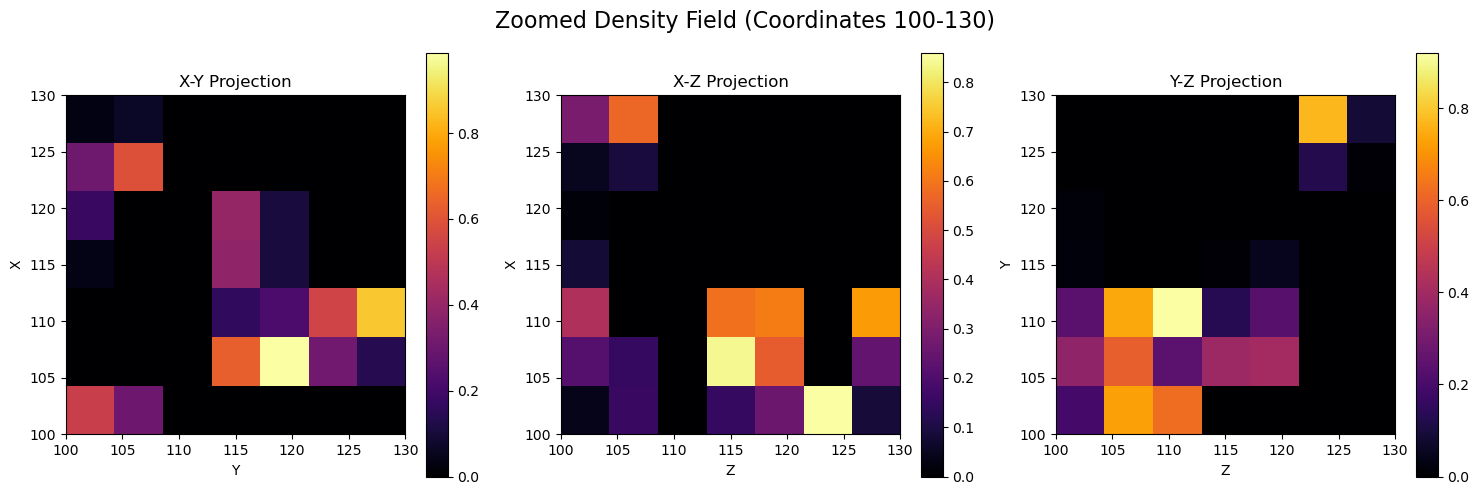

(<Figure size 1500x500 with 6 Axes>,
 array([<Axes: title={'center': 'X-Y Projection'}, xlabel='Y', ylabel='X'>,
        <Axes: title={'center': 'X-Z Projection'}, xlabel='Z', ylabel='X'>,
        <Axes: title={'center': 'Y-Z Projection'}, xlabel='Z', ylabel='Y'>],
       dtype=object))

In [71]:
plot_zoomed_density_field(input_field, min_coord=100, max_coord=130)

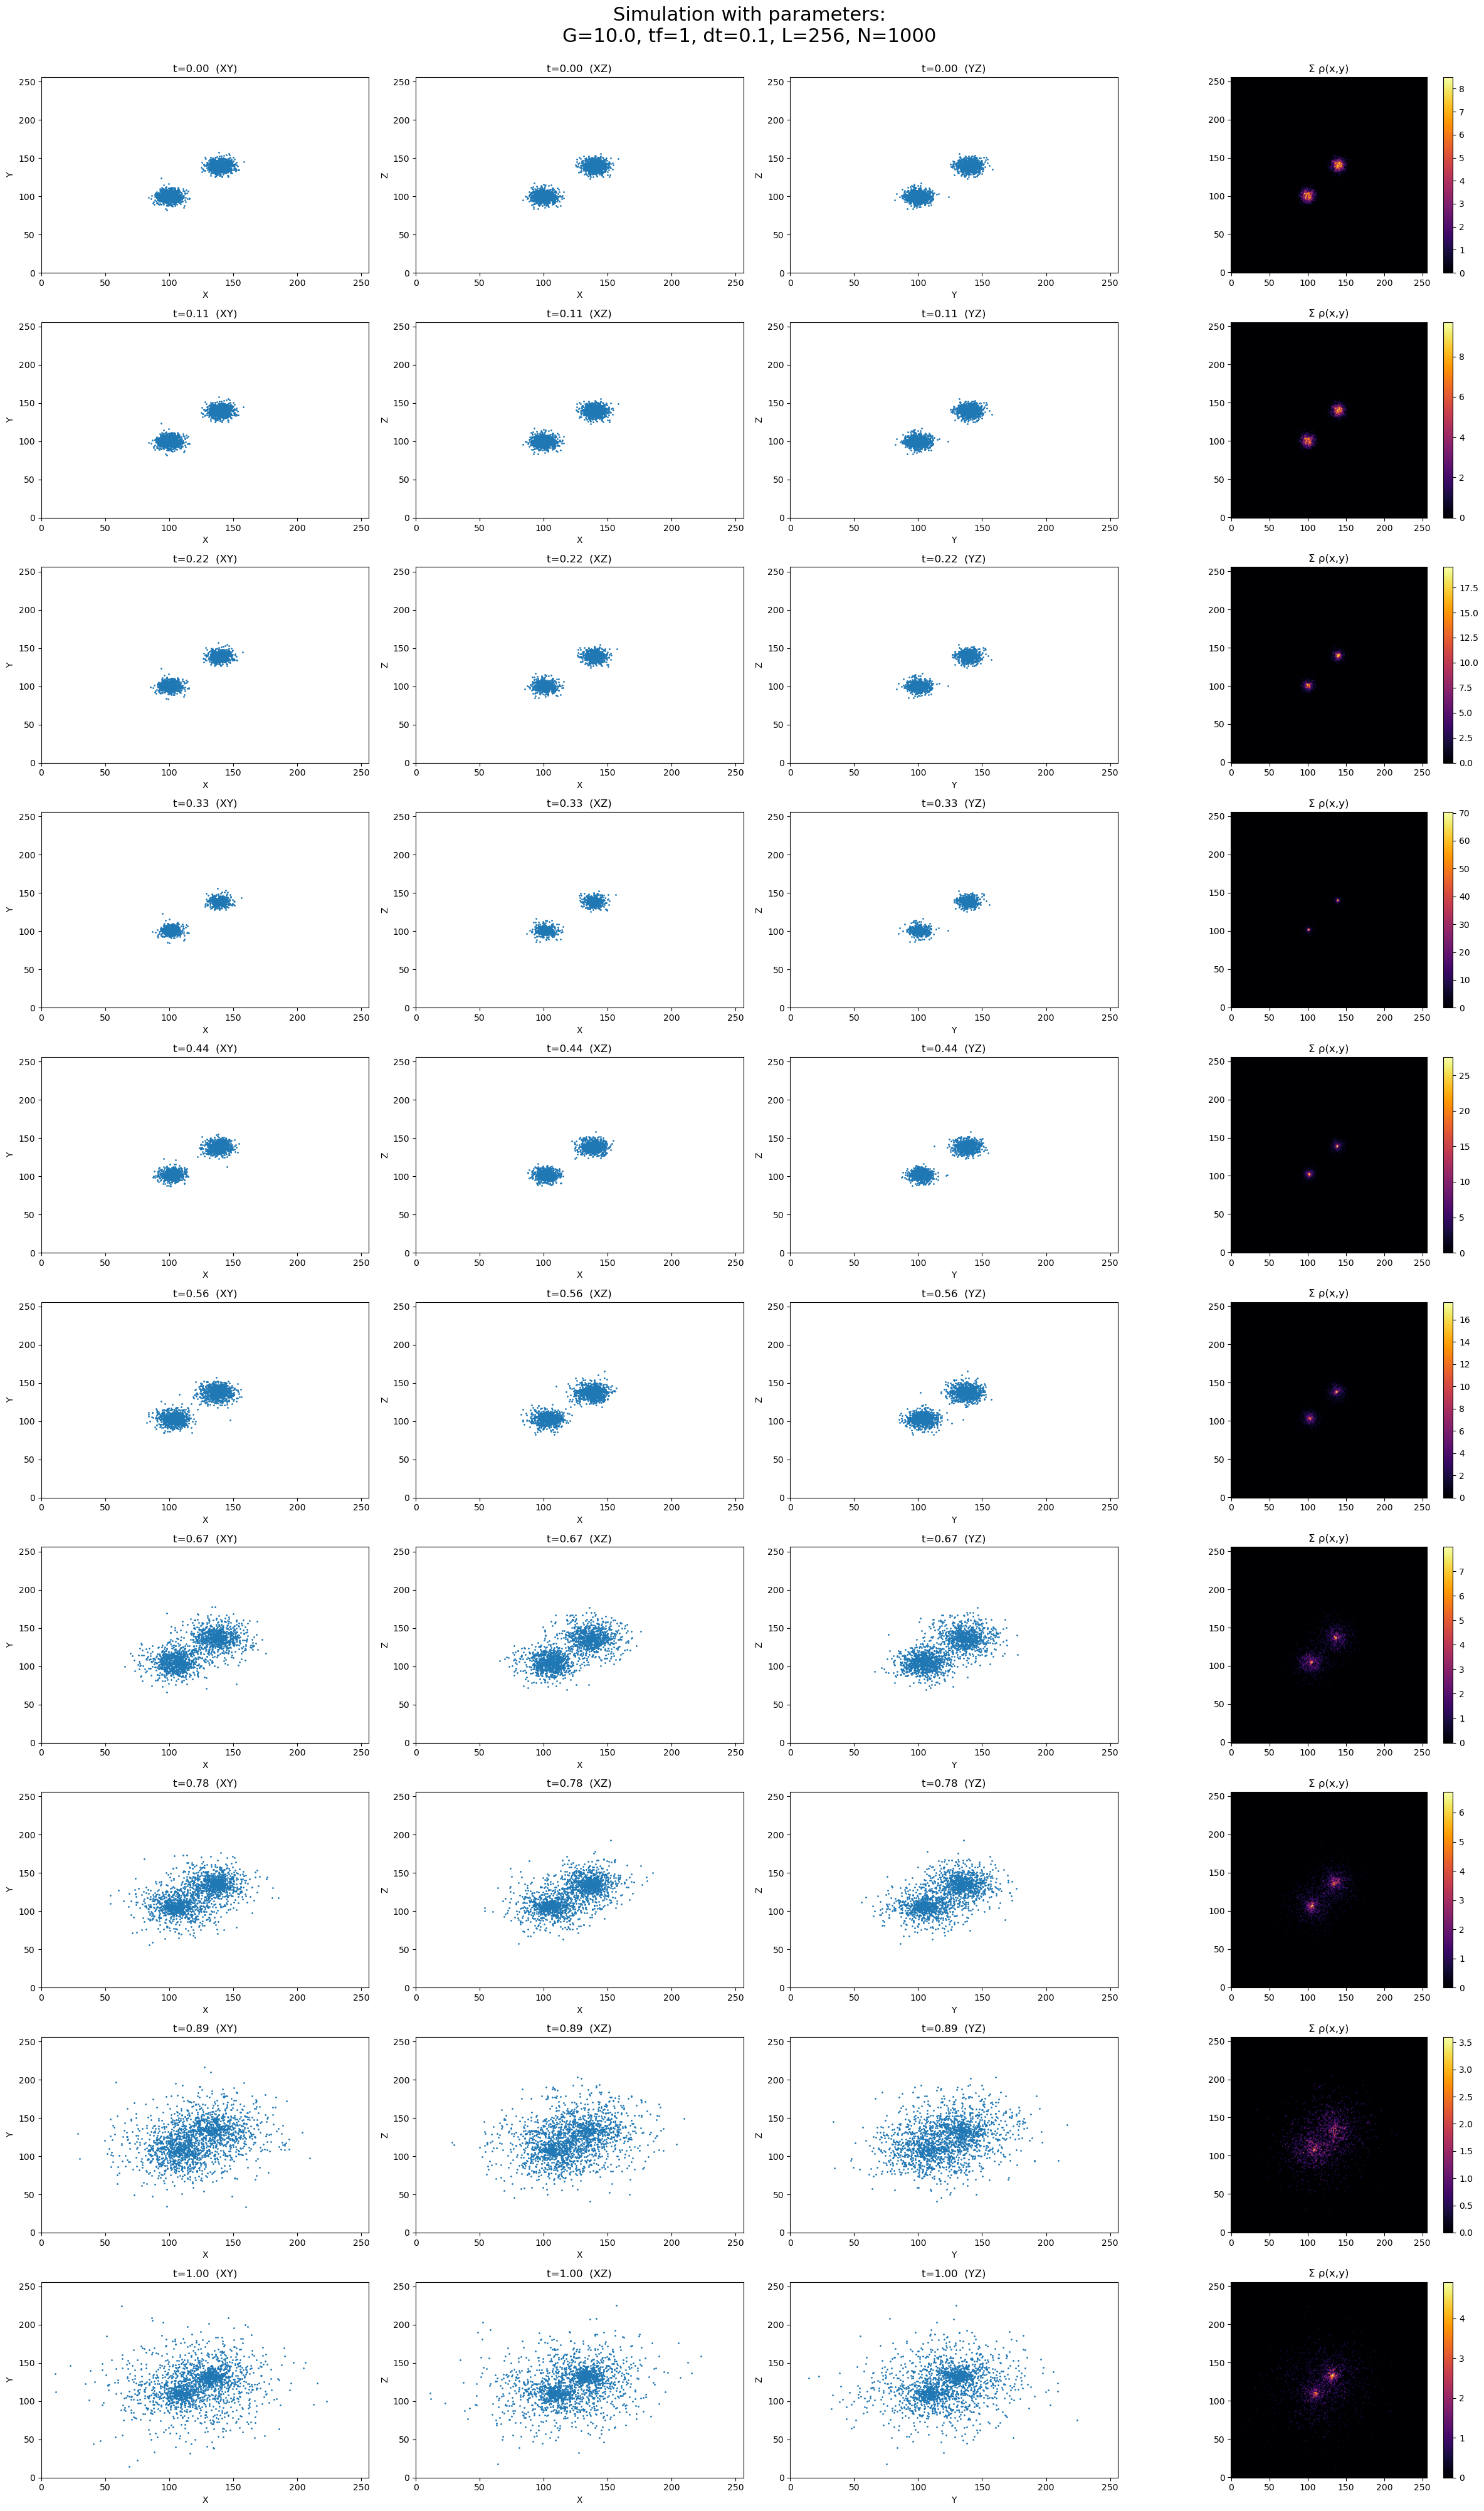

(<Figure size 2400x4000 with 50 Axes>,
 array([[<Axes: title={'center': 't=0.00  (XY)'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 't=0.00  (XZ)'}, xlabel='X', ylabel='Z'>,
         <Axes: title={'center': 't=0.00  (YZ)'}, xlabel='Y', ylabel='Z'>,
         <Axes: title={'center': 'Σ ρ(x,y)'}>],
        [<Axes: title={'center': 't=0.11  (XY)'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 't=0.11  (XZ)'}, xlabel='X', ylabel='Z'>,
         <Axes: title={'center': 't=0.11  (YZ)'}, xlabel='Y', ylabel='Z'>,
         <Axes: title={'center': 'Σ ρ(x,y)'}>],
        [<Axes: title={'center': 't=0.22  (XY)'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 't=0.22  (XZ)'}, xlabel='X', ylabel='Z'>,
         <Axes: title={'center': 't=0.22  (YZ)'}, xlabel='Y', ylabel='Z'>,
         <Axes: title={'center': 'Σ ρ(x,y)'}>],
        [<Axes: title={'center': 't=0.33  (XY)'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 't=0.33  (XZ)'}, xlabel='X', ylabe

In [49]:
plot_all_timesteps(sol, G=G, tf=tf, dt=dt, n_part=n_part, boxL=length, skip=skip)

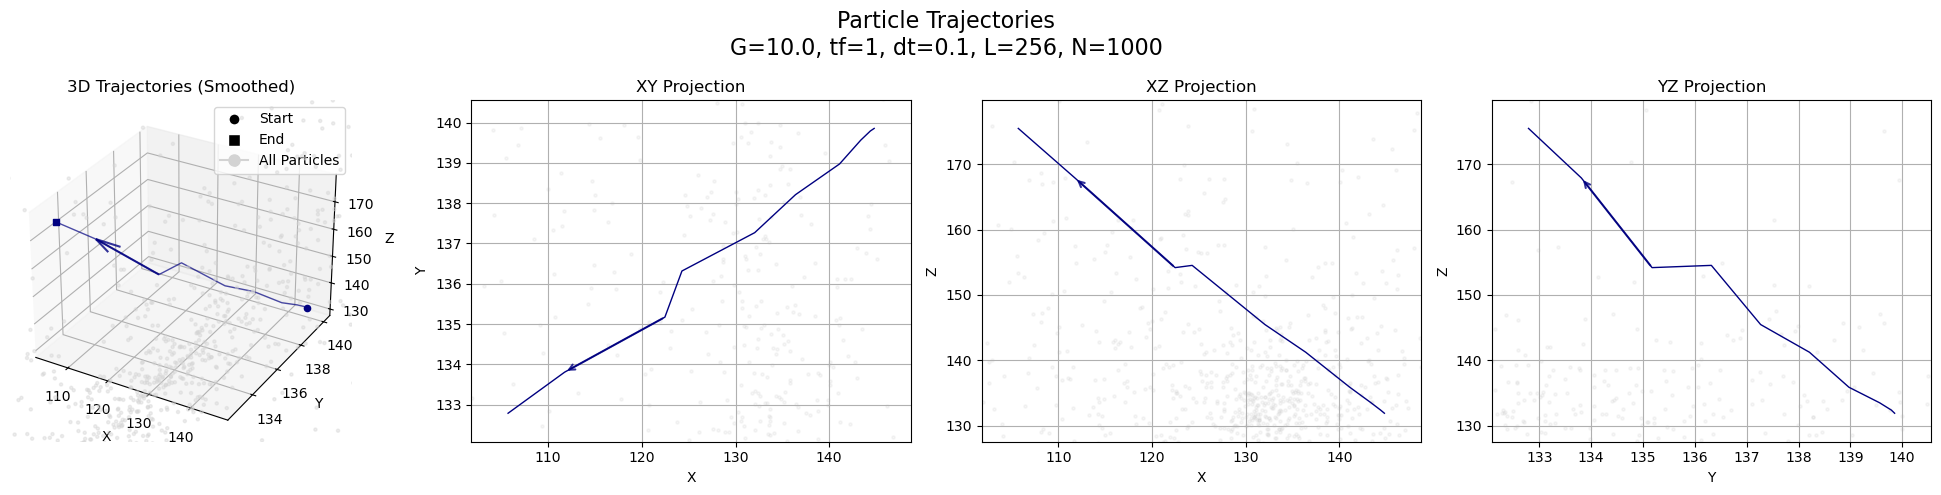

In [51]:
# Example usage:
particle_indices = np.random.choice(np.shape(sol.ys)[2], 1, replace=False)  # Randomly select 10 particles

# Example usage:
fig = plot_trajectories(sol, G=G, tf=tf, dt=dt, length=length, n_part=n_part, particle_indices=particle_indices, smooth_window=3, title="Particle Trajectories")
plt.show()

## Conservation of energy sanity check

In [54]:
# Add these functions to calculate conservation quantities
def calculate_momentum(pos, vel):
    """Calculate total momentum of the system in each dimension."""
    return jnp.sum(vel, axis=0)  # Returns [px_total, py_total, pz_total]

def calculate_kinetic_energy(vel):
    """Calculate total kinetic energy of the system."""
    return 0.5 * jnp.sum(jnp.sum(vel**2, axis=1))

def calculate_potential_energy(pos, softening, grav, length):
    """Calculate total potential energy of the system."""
    dx = pos[:,None,:] - pos[None,:,:]  # (N,N,3)
    dx = dx - length*jnp.round(dx/length)  # periodic
    r2 = jnp.sum(dx**2, axis=-1) + softening**2  # (N,N)
    r_inv = jnp.where(jnp.eye(pos.shape[0]), 0., jnp.sqrt(r2)**-1)
    
    return -0.5 * grav * jnp.sum(r_inv)

def track_conservation(solution, grav, softening, length):
    n_timesteps = solution.ts.shape[0]
    
    # Create arrays to store conservation values
    momentum = np.zeros((n_timesteps, 3))
    kinetic_energy = np.zeros(n_timesteps)
    potential_energy = np.zeros(n_timesteps)
    total_energy = np.zeros(n_timesteps)
    
    # Calculate conservation quantities at each timestep
    for i in range(n_timesteps):
        pos = solution.ys[i, 0]  # positions at timestep i
        vel = solution.ys[i, 1]  # velocities at timestep i
        
        momentum[i] = np.array(calculate_momentum(pos, vel))
        kinetic_energy[i] = float(calculate_kinetic_energy(vel))
        potential_energy[i] = float(calculate_potential_energy(pos, softening=softening, grav=grav, length=length))
        total_energy[i] = kinetic_energy[i] + potential_energy[i]
    
    # Print ranges to help with debugging
    print(f"Momentum range: {momentum.min():.2e} to {momentum.max():.2e}")
    print(f"Kinetic energy range: {kinetic_energy.min():.2e} to {kinetic_energy.max():.2e}")
    print(f"Potential energy range: {potential_energy.min():.2e} to {potential_energy.max():.2e}")
    print(f"Total energy range: {total_energy.min():.2e} to {total_energy.max():.2e}")
    
    return {
        'ts': solution.ts,
        'momentum': momentum,
        'kinetic_energy': kinetic_energy,
        'potential_energy': potential_energy,
        'total_energy': total_energy
    }

# After your simulation:
conservation = track_conservation(sol, grav=G, softening=softening, length=length)

TypeError: tuple indices must be integers or slices, not tuple

Complete forward model

In [ ]:
master_key = random.PRNGKey(123456) 

pos_key, vel_key = random.split(master_key, 2)
keys = jnp.array([pos_key, vel_key])


def gaussian_model(parameters,n_part = 1000, keys=keys):
    sigma,mean,vel_sigma = parameters
    init_pos = random.normal(keys[0], shape=(n_part,3)) * sigma + mean
    init_vel = random.normal(keys[1], shape=(n_part,3)) * vel_sigma
    y0 = jnp.stack([init_pos, init_vel],axis=0)

    solution = diffeqsolve(term, solver, t0=0, t1=1, dt0=0.5, y0=y0)
    output_field = cic_paint(jnp.zeros((64,64,64)),solution.ys[0][0])
    return output_field

In [ ]:
def log_likelihood_1(parameters): 
    out = gaussian_model(parameters)
    return - jnp.sum((out-data)**2) 

jvag = jax.value_and_grad(log_likelihood_1)